In [1]:
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(lme4)))
suppressWarnings(suppressMessages(library(boot)))

# import income functions
suppressMessages(source("../../src/income.R"))

select = dplyr::select

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6)

In [3]:
acs = read_csv("../../data/acs/block_group_census_estimates_wide_wsdot_bins.csv", col_types="cccciiddddddddddddddddddd") %>%
    filter(mean_inc < Inf, !is.na(med_inc)) %>%
    mutate(fips = fips_code) %>% select(-fips_code)
acs_bins = c(0, 20, 35, 50, 75, 100, 125, 150, 200, Inf)

# There is substantial income variation within census blocks

The area-wide income IQR is 85k, whereas the median IQR for a census block is 57k. We use IQRs instead of standard deviations because the latter are difficult to estimate robustly for individual census blocks.

In [699]:
sd(acs$mean_inc, na.rm=T)
sd(acs$pc_income, na.rm=T)

[1] 45510.76

[1] 17880.76

In [ ]:
est_iqr = function(row, ...) {
    fit = fit_dagum(row$count, acs_bins)
    1000*(qinc(0.75, fit) - qinc(0.25, fit))
}

acs %>% 
    drop_na(med_inc) %>%
    mutate_at(vars(starts_with("inc")), ~ . * population) %>%
    select(fips, starts_with("inc")) %>%
    gather(inc_group, count, -fips) %>%
    arrange(fips, inc_group) %>%
    group_by(fips) %>%
    group_map(est_sd)  %>%
    as.numeric %>%
    median

In [4]:
all_counts = acs %>% 
    mutate(group="All") %>%
    inc_distr_by(group, weight=population) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct)

all_counts
#est_iqr(all_counts)

group count    inc_group    pct       
1 All   544071.4 inc_000_020k 0.11257330
2 All   518097.8 inc_020_035k 0.10719912
3 All   544646.2 inc_035_050k 0.11269223
4 All   851807.2 inc_050_075k 0.17624664
5 All   669751.1 inc_075_100k 0.13857757
6 All   515703.4 inc_100_125k 0.10670371
7 All   352420.1 inc_125_150k 0.07291892
8 All   402251.1 inc_150_200k 0.08322940
9 All   434292.8 inc_200_infk 0.08985911

A fitted Dagum distribution with b = 121.38, a = 2.8, and p = 0.43

4833041 total observation(s)
Bins: 0 20 35 50 75 100 125 150 200 Inf


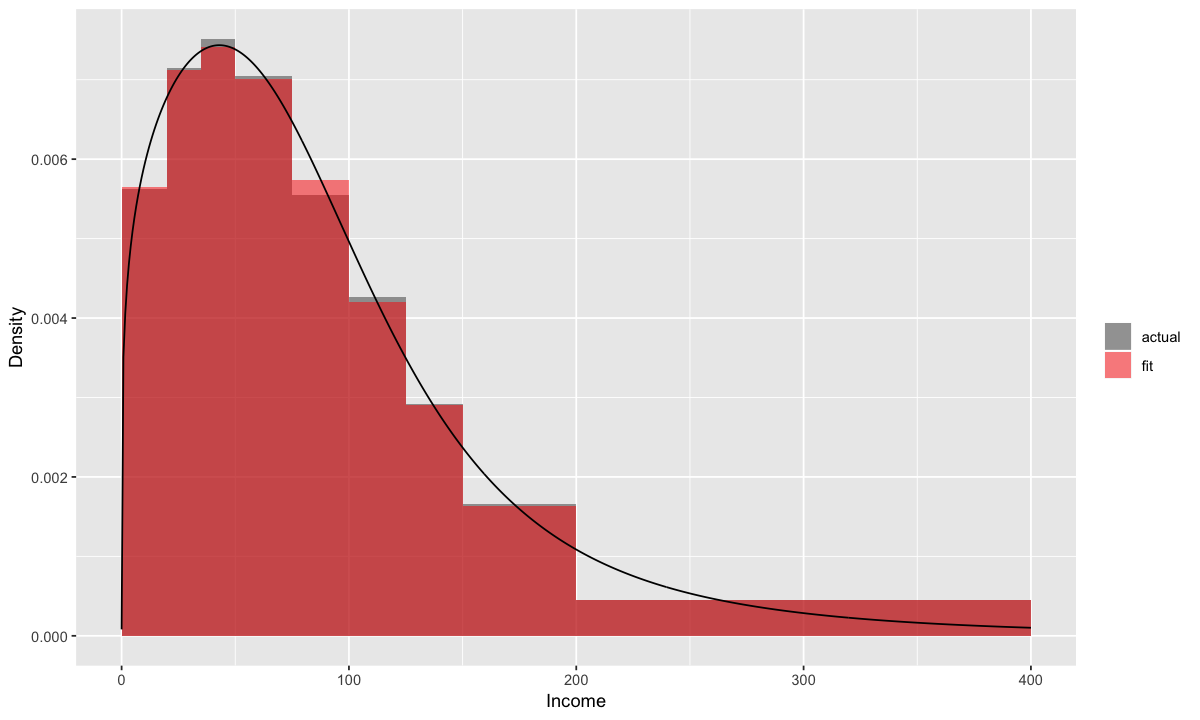

In [5]:
fit_all = fit_dagum(all_counts$count, acs_bins)
b = fit_all$par[1]
a = fit_all$par[2]
p = fit_all$par[3]

print(fit_all)
plot(fit_all, 400)

# Simulating driving patterns, assuming no block-income interaction

In [49]:
get_pars = function(row, ...) {
    fit = tryCatch(fit_dagum(row$count, acs_bins), error=function(e) list(par=c(NA, NA, NA)))
    tibble(b=fit$par[1], a=fit$par[2], p=fit$par[3])
}

fips_pars = acs %>% 
    drop_na(med_inc) %>%
    mutate_at(vars(starts_with("inc")), ~ . * population) %>%
    select(fips, starts_with("inc")) %>%
    gather(inc_group, count, -fips) %>%
    arrange(fips, inc_group) %>%
    group_by(fips) %>%
    group_modify(get_pars) %>%
    left_join(acs, "fips") %>%
    mutate(tract=paste0(county, tract))

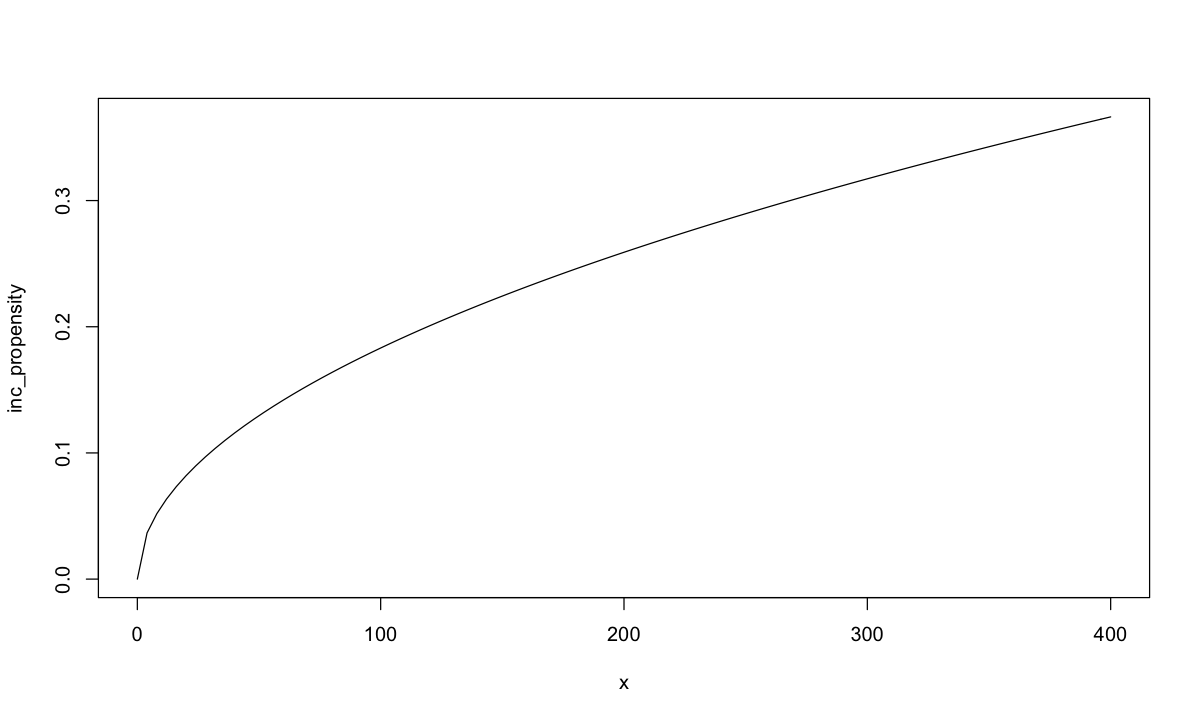

In [50]:
inc_propensity = function(income) {
    exp(log(income)*0.5 - 4)
}

plot(inc_propensity, xlim=c(0, 400))

In [51]:
counties = unique(fips_pars$county)
cty_offset = rnorm(length(counties), 0.0, 0.7)
names(cty_offset) = counties
cty_offset

tracts = unique(fips_pars$tract)
tr_offset = rnorm(length(tracts), 0.0, 0.2)
names(tr_offset) = tracts
head(tr_offset)

033         035         037         053         057         061 
 0.74292437 -0.02433248 -0.76667921  0.86757529  0.53181561  0.36878333 
        067         073         077 
 1.87697578  0.32032306 -0.44904375

033000100    033000200    033000300    033000401    033000402    033000500 
 0.117458780  0.075868108 -0.382029127  0.008164399  0.047593727  0.220015531

In [52]:
simulate_block = function(pop, cty, tr, b, a, p) {
    incomes = rdagum(pop, b, a, p)
    probs = exp(log(inc_propensity(incomes)) + cty_offset[cty] + tr_offset[tr])
    probs[probs > 1000] = 1000
    sum(rpois(pop, probs))
}

fips_drivers = fips_pars %>%
    drop_na %>%
    rowwise() %>%
    mutate(n = simulate_block(households, county, tract, b, a, p))
simul_ecolg = fips_drivers %>% 
    mutate(group="Ecological") %>%
    inc_distr_by(group, weight=n) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct)

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [6]:
count_bins = function(incomes, drivers) {
    tibble(inc_000_020k = weighted.mean(incomes >= 0 & incomes < 20, w=drivers),
           inc_020_035k = weighted.mean(incomes >= 20 & incomes < 35, w=drivers),
           inc_035_050k = weighted.mean(incomes >= 35 & incomes < 50, w=drivers),
           inc_050_075k = weighted.mean(incomes >= 50 & incomes < 75, w=drivers),
           inc_075_100k = weighted.mean(incomes >= 75 & incomes < 100, w=drivers),
           inc_100_125k = weighted.mean(incomes >= 100 & incomes < 125, w=drivers),
           inc_125_150k = weighted.mean(incomes >= 125 & incomes < 150, w=drivers),
           inc_150_200k = weighted.mean(incomes >= 150 & incomes < 200, w=drivers),
           inc_200_infk = weighted.mean(incomes >= 200, w=drivers),
           count = sum(drivers))
}

In [54]:
simulate_indiv = function(pop, cty, tr, b, a, p) {
    N = round(pop*0.2)
    incomes = rdagum(N, b, a, p)
    probs = exp(log(inc_propensity(incomes)) + cty_offset[cty] + tr_offset[tr])
    probs[probs > 1000] = 1000
    drivers = rpois(N, probs)
    count_bins(incomes, drivers)
}

fips_drivers_2 = fips_pars %>%
    drop_na %>%
    group_modify(~ simulate_indiv(.$population, .$county, .$tract, .$b, .$a, .$p))

In [55]:
simul_indiv = fips_drivers_2 %>% 
    mutate(group="Actual") %>%
    inc_distr_by(group, weight=count) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct)

In [56]:
N_total = sum(fips_pars$households)
b = fit_all$par[1]
a = fit_all$par[2]
p = fit_all$par[3]

incomes = rdagum(N_total, b, a, p)
#incomes = rweibull(N_total, a, b)
probs = inc_propensity(incomes)
probs[probs > 1000] = 1000
drivers = rpois(N_total, probs)

simul_indiv_2 = count_bins(incomes, drivers) %>%
    mutate(group="Individual") %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = pct*count)

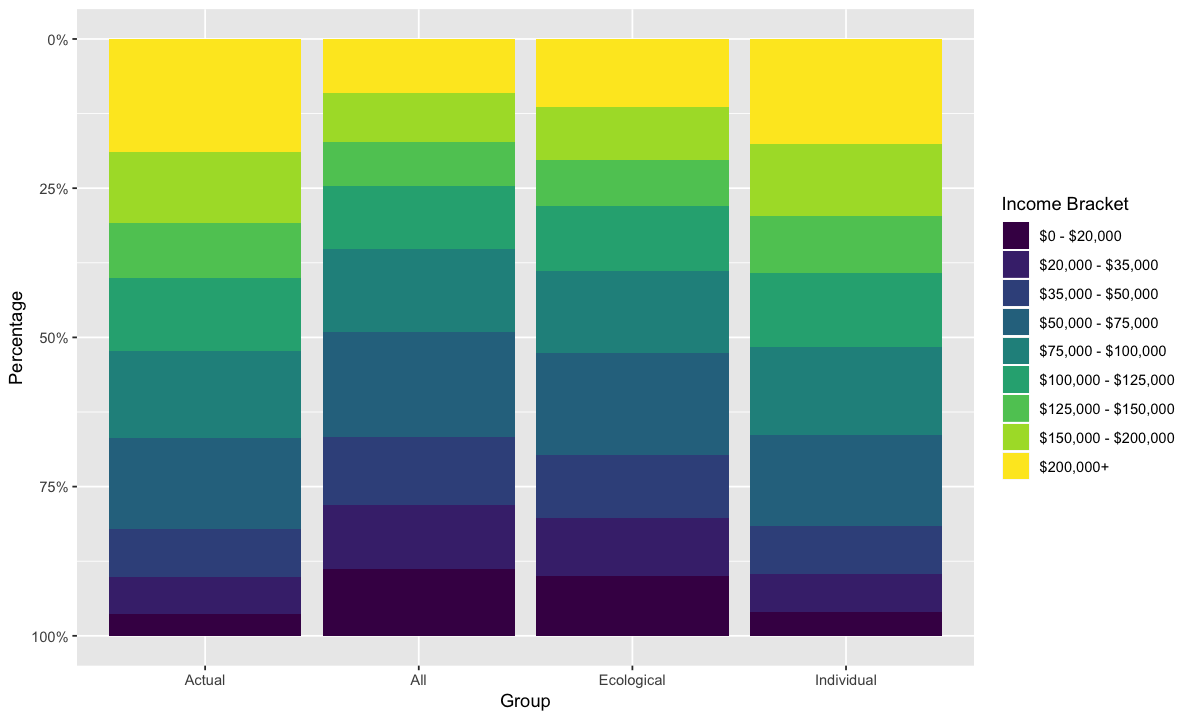

In [57]:
simul_ecolg %>% 
    bind_rows(all_counts) %>%
    bind_rows(simul_indiv) %>%
    bind_rows(simul_indiv_2) %>%
    select(-count) %>% 
    spread(inc_group, pct) %>%
    plot_inc_stacked

In [58]:
scales::dollar(1000*median(fit_dagum(simul_indiv$count, acs_bins)))
scales::dollar(1000*median(fit_dagum(simul_indiv_2$count, acs_bins)))
scales::dollar(1000*median(fit_dagum(simul_ecolg$count, acs_bins)))
scales::dollar(1000*median(fit_dagum(all_counts$count, acs_bins)))

[1] "$104,231"

[1] "$102,896"

[1] "$79,498.56"

[1] "$74,020.37"

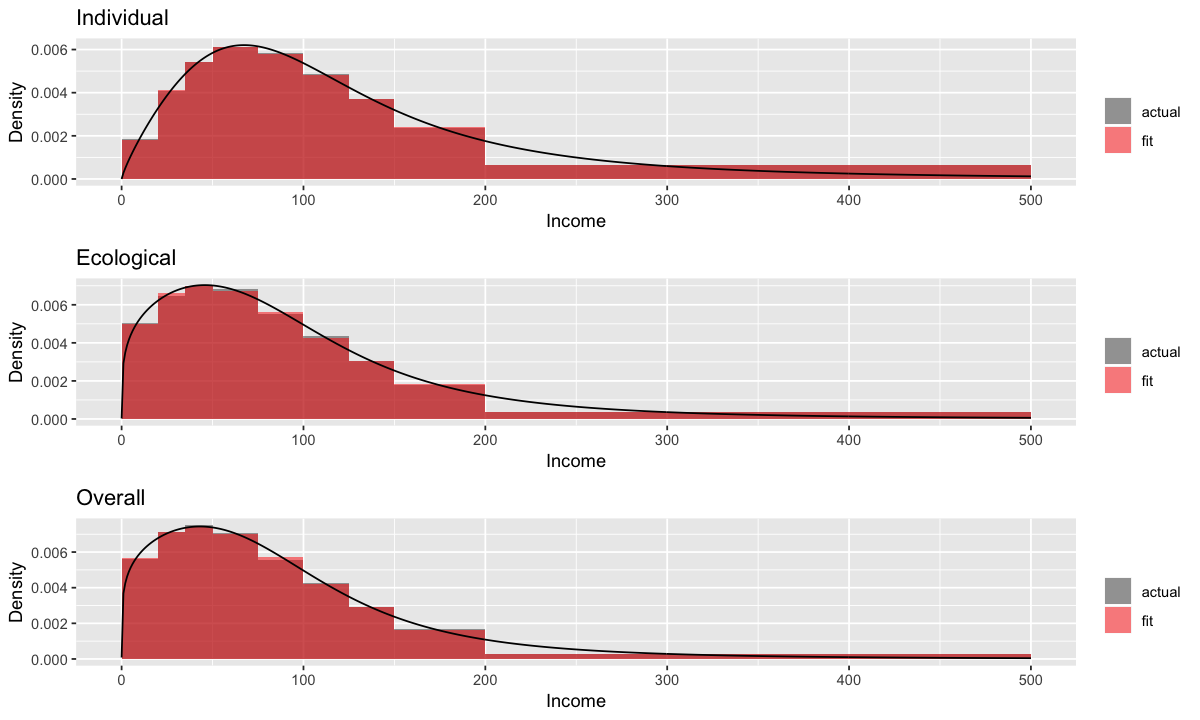

In [59]:
p1 = plot(fit_dagum(simul_indiv$count, acs_bins), 500) + labs(title="Individual")
p2 = plot(fit_dagum(simul_ecolg$count, acs_bins), 500) + labs(title="Ecological")
p3 = plot(fit_dagum(all_counts$count, acs_bins), 500) + labs(title="Overall")

gridExtra::grid.arrange(p1, p2, p3, nrow=3)

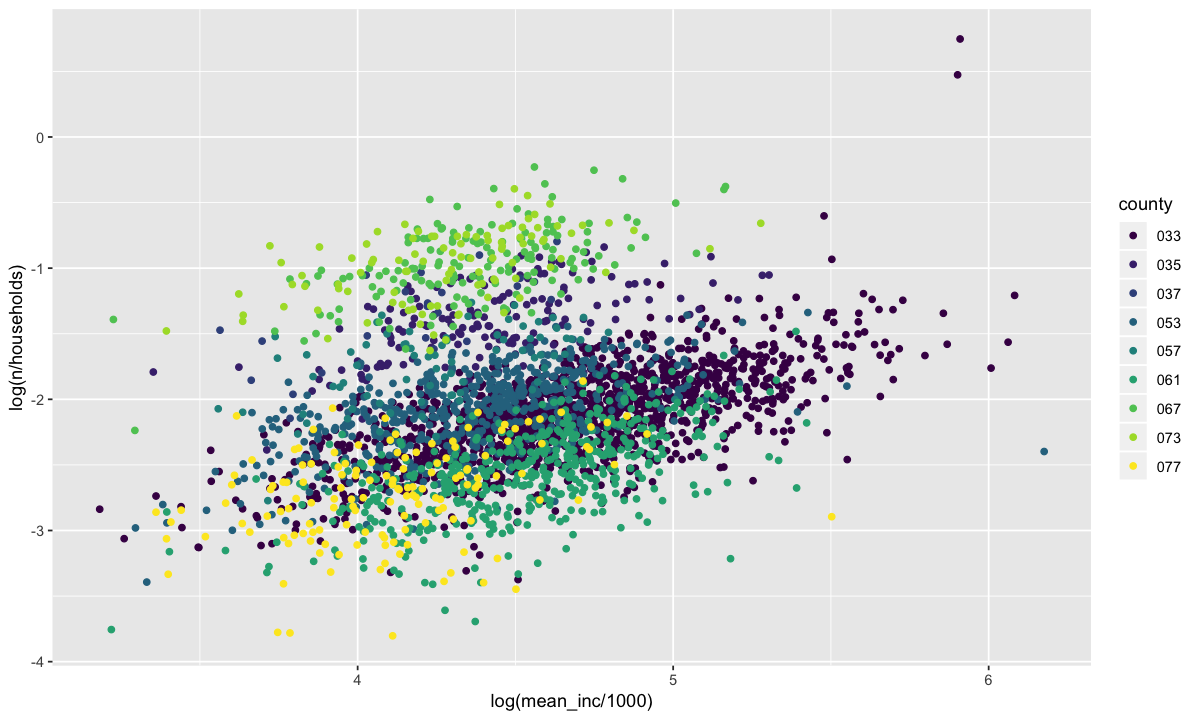

In [215]:
ggplot(fips_drivers, aes(log(mean_inc/1000), log(n/households), color=county)) + 
    geom_point() + scale_color_viridis_d()

In [60]:
m = lmer(log(n/households) ~ log(mean_inc/1000) + (log(mean_inc/1000)|tract), data=fips_drivers %>% filter(n>=0))
summary(m)
#coef(m)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0195884 (tol = 0.002, component 1)”

Linear mixed model fit by REML ['lmerMod']
Formula: log(n/households) ~ log(mean_inc/1000) + (log(mean_inc/1000) |  
    tract)
   Data: fips_drivers %>% filter(n >= 0)

REML criterion at convergence: -206.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8304 -0.4174  0.0171  0.4394 10.3171 

Random effects:
 Groups   Name               Variance Std.Dev. Corr 
 tract    (Intercept)        1.12018  1.0584        
          log(mean_inc/1000) 0.03828  0.1956   -0.88
 Residual                    0.01522  0.1234        
Number of obs: 3102, groups:  tract, 935

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        -3.52939    0.06382  -55.30
log(mean_inc/1000)  0.51624    0.01347   38.32

Correlation of Fixed Effects:
            (Intr)
lg(m_/1000) -0.966
convergence code: 0
Model failed to converge with max|grad| = 0.0195884 (tol = 0.002, component 1)


In [79]:
est_m = function(d, i) {
    d = d[i,]
    m = lmer(log(n/households) ~ log(mean_inc/1000) + (log(mean_inc/1000)|tract), data=d, 
         control=lmerControl(optCtrl=list(ftol_abs=1e-8, xtol_abs=1e-8)))
    fixef(m)
}

est_m.d = filter(fips_drivers, n>=0)
bm2 = boot(est_m.d, est_m, R=50, strata=est_m.d$tract)
bm2

boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00409649 (tol = 0.002, component 1)”boundary (singular) fit: see ?isSingular
boundary (singular) fit: see ?isSingular
boundary (si


STRATIFIED BOOTSTRAP


Call:
boot(data = est_m.d, statistic = est_m, R = 50, strata = est_m.d$tract)


Bootstrap Statistics :
      original       bias    std. error
t1* -3.8557226  0.002526731  0.08271190
t2*  0.5556301 -0.001038549  0.01887557

In [60]:
broom::tidy(m)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

term                                     estimate   std.error  statistic
1 (Intercept)                              -3.8557226 0.06349195 -60.72774
2 log(mean_inc/1000)                        0.5556301 0.01451312  38.28468
3 sd_(Intercept).tract                      0.0000000         NA        NA
4 sd_log(mean_inc/1000).tract               0.1017473         NA        NA
5 cor_(Intercept).log(mean_inc/1000).tract        NaN         NA        NA
6 sd_Observation.Residual                   0.1909283         NA        NA
  group   
1 fixed   
2 fixed   
3 tract   
4 tract   
5 tract   
6 Residual

In [80]:
0.08271190/0.06349
0.01887557/0.014513

[1] 1.302755

[1] 1.300597

(Intercept) log(mean_inc/1000) 
         -3.529394           0.516242

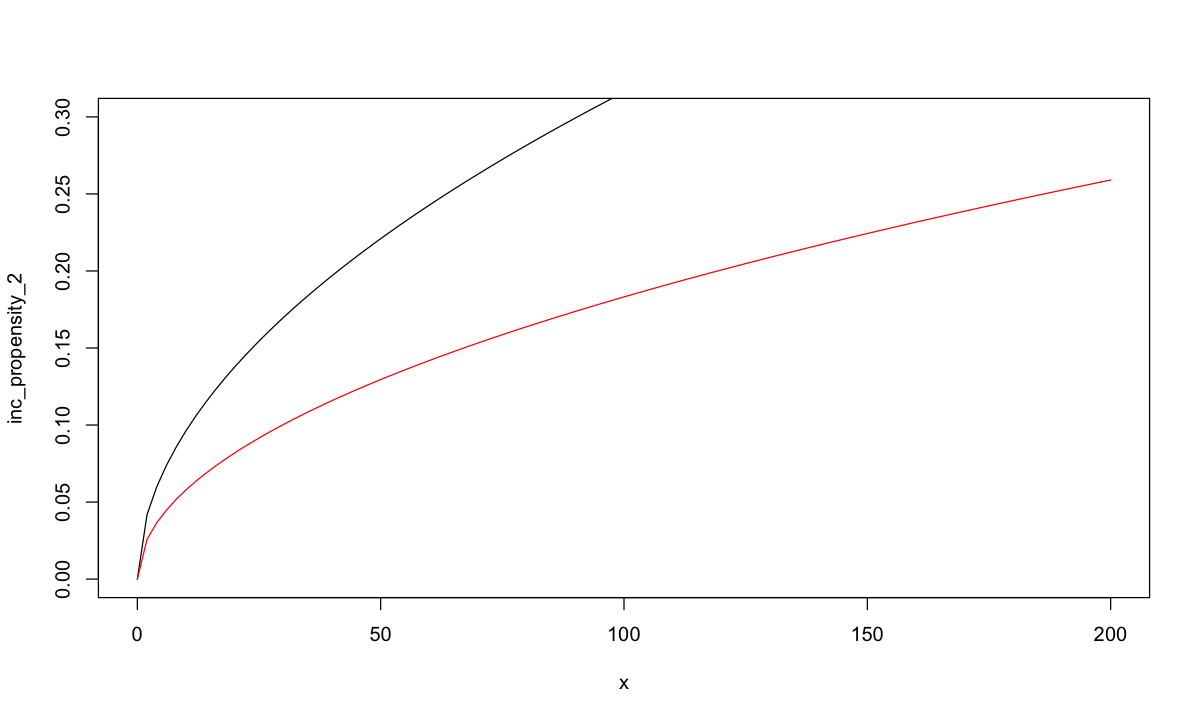

In [65]:
mcoef = apply(coef(m)$tract, 2, weighted.mean)
mcoef = colMeans(coef(m)$tract)
mcoef

inc_propensity_2 = function(income) {
    exp(log(income)*(mcoef[2])+ mcoef[1])
}

plot(inc_propensity_2, xlim=c(0, 200), ylim=c(0, .3))
#plot(inc_propensity_2, xlim=c(0, 200))
curve(inc_propensity, xlim=c(0, 200), col="red", add=T)

In [232]:
fips_drivers %>%
    drop_na %>%
    sample_n(100, weight=population) %>%
    group_by(fips) %>%
    group_modify(~ simulate_indiv_fit(.$population, .$tract, .$b, .$a, .$p)) ->
fips_drivers_3

In [233]:
head(fips_drivers_3)

fips         inc_000_020k inc_020_035k inc_035_050k inc_050_075k inc_075_100k
1 530330001002 0.084856344  0.11583169   0.14044846   0.23890474   0.17963164  
2 530330020001 0.043173412  0.04467105   0.05017647   0.09179262   0.09758238  
3 530330025001 0.026506512  0.03629554   0.04597844   0.09380674   0.11000904  
4 530330035002 0.023099386  0.03241679   0.04107199   0.08206117   0.09176750  
5 530330045002 0.003757241  0.01586045   0.03208392   0.08354074   0.10147106  
6 530330067001 0.002405570  0.01017996   0.02345622   0.08117969   0.14079341  
  inc_100_125k inc_125_150k inc_150_200k inc_200_infk count   
1 0.10518495   0.05623976   0.04745193   0.0314505    144.5976
2 0.09844915   0.09437045   0.16077185   0.3190126    240.7793
3 0.11887385   0.11811154   0.19623437   0.2541840    251.0551
4 0.09378912   0.08961299   0.15260013   0.3935809    231.6313
5 0.10079031   0.09092898   0.14472693   0.4268404    359.7719
6 0.18000998   0.17375582   0.22382733   0.1643920    411.7432

In [122]:
simulate_indiv_fit = function(pop, tr, b, a, p) {
    N = max(round(pop*0.001), 2)
    incomes = rdagum(N, b, a, p)
    #drivers = exp(simulate(m, nsim=1, newdata=tibble(mean_inc=incomes, tract=tr))$sim_1)
    mcoefs = coef(m)$tract[tr,]
    drivers = exp(log(incomes)*mcoef[2] + mcoef[1])
    count_bins(incomes, drivers)
}

In [171]:
simulate_indiv_fit = function(pop, tr, b, a, p) {
    #N = max(round(pop*0.001), 2)
    #incomes = rdagum(N, b, a, p)
    mcoefs = coef(m)$tract[tr,]
    prop_weight = function(x) exp(log(x)*mcoef[2] + mcoef[1])
    norm = integrate(function(x) prop_weight(x) * ddagum(x, b, a, p), 0, 1e3)$value
    p_inc = function(q) integrate(function(x) prop_weight(x) * ddagum(x, b, a, p), 0, q)$value / norm
    cuml = c(sapply(acs_bins[1:(length(acs_bins)-1)], p_inc), 1)
    tibble(inc_group=all_counts$inc_group, pct=diff(cuml)) %>%
        spread(inc_group, pct) %>%
        mutate(count = pop*norm)
}

In [193]:
fips_drivers_3 = fips_drivers %>%
    drop_na %>%
    sample_n(500) %>%
    group_by(fips) %>%
    group_modify(~ simulate_indiv_fit(.$population, .$tract, .$b, .$a, .$p))

In [173]:
head(fips_drivers_3)

fips         inc_000_020k inc_020_035k inc_035_050k inc_050_075k inc_075_100k
1 530330001003 0.0820083661 0.071096018  0.07477530   0.12967057   0.13183216  
2 530330002001 0.0004916946 0.008497448  0.04407562   0.23130780   0.30288594  
3 530330002006 0.0106516527 0.025824740  0.04230830   0.10229585   0.12582426  
4 530330003001 0.0206966993 0.036659054  0.05178661   0.11259927   0.13083665  
5 530330003002 0.0607700262 0.073774790  0.08649525   0.15532681   0.14692686  
6 530330005002 0.0257657108 0.031108605  0.03733270   0.07299227   0.08399439  
  inc_100_125k inc_125_150k inc_150_200k inc_200_infk count   
1 0.12694470   0.11219583   0.15197254   0.11950453   171.1753
2 0.19535251   0.09940932   0.07629915   0.04168053   145.5002
3 0.12743493   0.11339239   0.16662907   0.28563882   198.3058
4 0.13009165   0.11464944   0.16431863   0.23836200   165.3750
5 0.12166406   0.09224377   0.11452449   0.14827394   162.3060
6 0.09325655   0.10136939   0.22371870   0.33046168   107.3102

In [234]:
N_total = sum(fips_pars$households)

incomes = rdagum(N_total, b, a, p)
#incomes = rweibull(N_total, a, b)
probs = inc_propensity_2(incomes)
probs[probs > 1000] = 1000
drivers = rpois(N_total, probs)

simul_indiv_fit = count_bins(incomes, drivers) %>%
    mutate(group="Synthetic") %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = pct*count)

In [235]:
simul_indiv_fit_2 = fips_drivers_3 %>%
    mutate(group="A_Synthetic") %>%
    inc_distr_by(group, weight=count) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = pct*count)

[1] "$98,752.31"

[1] "$102,777"

[1] "$102,280"

[1] "$101,288"

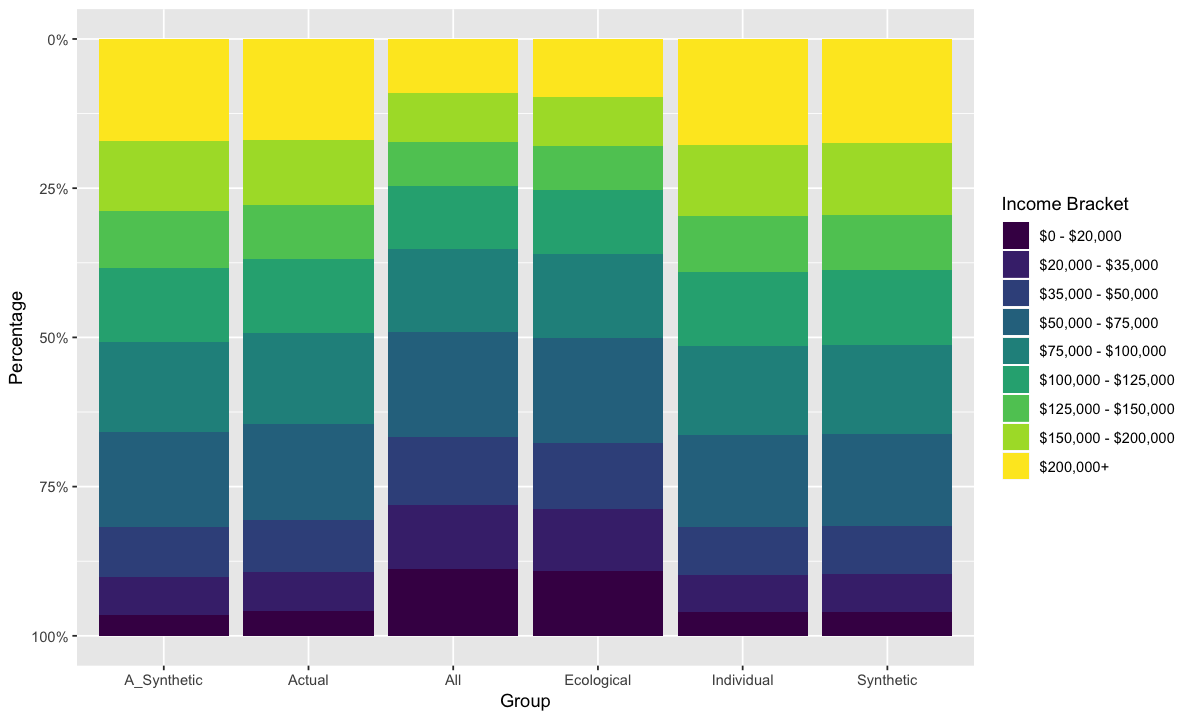

In [236]:
scales::dollar(1000*median(fit_dagum(simul_indiv$count, acs_bins)))
scales::dollar(1000*median(fit_dagum(simul_indiv_2$count, acs_bins)))
scales::dollar(1000*median(fit_dagum(simul_indiv_fit$count, acs_bins)))
scales::dollar(1000*median(fit_dagum(simul_indiv_fit_2$count, acs_bins)))

simul_indiv %>% 
    bind_rows(simul_ecolg) %>%
    bind_rows(all_counts) %>%
    bind_rows(simul_indiv_2) %>%
    bind_rows(simul_indiv_fit) %>%
    bind_rows(simul_indiv_fit_2) %>%
    select(-count) %>% 
    spread(inc_group, pct) %>%
    plot_inc_stacked

# Ecological Regression

In [6]:
db_path = "../../../data/hot.db"
trips = load_table(db_path, "trips_linked")

In [7]:
trips.2pct = load_table(db_path, "trips_2pct", 
                        c(tag_id="c", acct="c", plate="c", id="c", zip="c")) %>% 
    execute %>%
    mutate(fips=as.character(fips))

Warning message:
“Unnamed `col_types` should have the same length as `col_names`. Using smaller of the two.”Warning message:
“13 parsing failures.
  row col expected actual         file
 7410 zip a double V5S1E8 literal data
 8031 zip a double V3W7X4 literal data
25917 zip a double V3W7X4 literal data
39147 zip a double V3W7X4 literal data
82255 zip a double V3W7X4 literal data
..... ... ........ ...... ............
See problems(...) for more details.
”

In [8]:
fips_counts = trips.2pct %>%
    filter(commercial==0, is_hov==0) %>%
    #mutate(toll = ceiling(toll)) %>%
    select(fips, id) %>%
    #distinct() %>%
    group_by(fips) %>%
    #summarize(count=n(), toll=mean(toll)) %>%
    summarize(count=n()) %>%
    #execute(col_types="ci") %>%
    drop_na

In [9]:
summary(fips_counts$count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    4.00   12.00   36.24   39.00  641.00 

In [10]:
fips_trips = fips_counts %>%
    inner_join(acs, by="fips") %>%
    filter(count >= 0) %>%
    mutate(tract = paste0("53", county, tract),
           tract2 = str_sub(tract, 1, -3),
           pc_income = pc_income/1000)
head(fips_trips)

fips         count county_name county tract       block_group households
1 530330001001 15    King        033    53033000100 1            608      
2 530330001002  6    King        033    53033000100 2            758      
3 530330001003  5    King        033    53033000100 3            724      
4 530330001004 18    King        033    53033000100 4           1052      
5 530330001005 10    King        033    53033000100 5            637      
6 530330002001  6    King        033    53033000200 1            545      
  inc_000_020k inc_020_035k inc_035_050k ⋯ med_age med_inc pc_income population
1 0.1282895    0.04934211   0.02467105   ⋯ 54.0    118026  82.066    1265      
2 0.2124011    0.06728232   0.25461741   ⋯ 37.0     46645  29.449    1534      
3 0.3135359    0.07182320   0.04143646   ⋯ 36.4     63000  32.027    1817      
4 0.2842205    0.20722433   0.15399240   ⋯ 29.3     35271  19.481    2270      
5 0.1930926    0.28571429   0.10518053   ⋯ 34.4     36250  33.317    1077      
6 0.0000000    0.00000000   0.10275229   ⋯ 44.2     85391  41.861    1183      
  race_nonhisp_asian race_nonhisp_white trans_carpool trans_drivealone
1 0.07667984         0.8774704          0.10102489    0.6105417       
2 0.07692308         0.5013038          0.07573633    0.6072931       
3 0.13538800         0.5976885          0.10266160    0.5674905       
4 0.14052863         0.2854626          0.11237113    0.5381443       
5 0.24698236         0.6350975          0.28549383    0.3935185       
6 0.07438715         0.7032967          0.09530387    0.5566298       
  trans_transit tract2   
1 0.1200586     530330001
2 0.2342216     530330001
3 0.2452471     530330001
4 0.2319588     530330001
5 0.1774691     530330001
6 0.1174033     530330002

There are 2873 census block groups with at least one trip in 2018.  They fit into 907 census tracts and 67 `tract2` units, which consist of the FIPS code for the tract, but without the last three digits.  

Most tracts contain at leats 2 block groups, with a median on 3 block groups.

In [11]:
nrow(fips_trips)
length(unique(fips_trips$tract))
length(unique(fips_trips$tract2))
with(fips_trips, weighted.mean(count/households, households))
with(fips_trips, median(count/households))

[1] 2354

[1] 756

[1] 410

[1] 0.06017934

[1] 0.02075407

In [12]:
fips_trips %>%
    group_by(tract) %>%
    summarize(n()) %>%
    pull %>%
    table %>%
    prop.table

.
          1           2           3           4           5           6 
0.067460317 0.228835979 0.369047619 0.222222222 0.084656085 0.025132275 
          7 
0.002645503 

A tomography plot suggests that ecological inference may be possible.


[Gelman, Andrew, et al. "Models, assumptions and model checking in ecological regressions." Journal of the Royal Statistical Society: Series A (Statistics in Society) 164.1 (2001): 101-118.](http://www.stat.columbia.edu/~gelman/research/published/ecological.pdf)

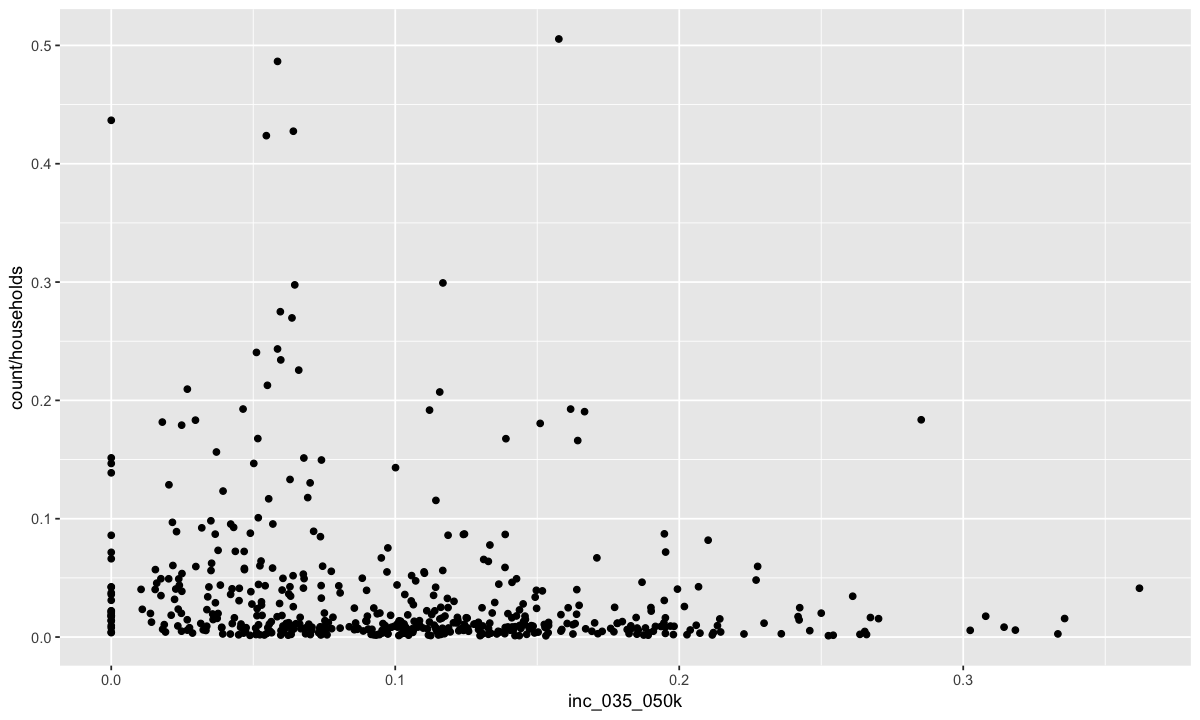

In [586]:
fips_trips %>%
    sample_n(500) %>%
ggplot(aes(x=inc_035_050k, y=count/households)) + geom_point()

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


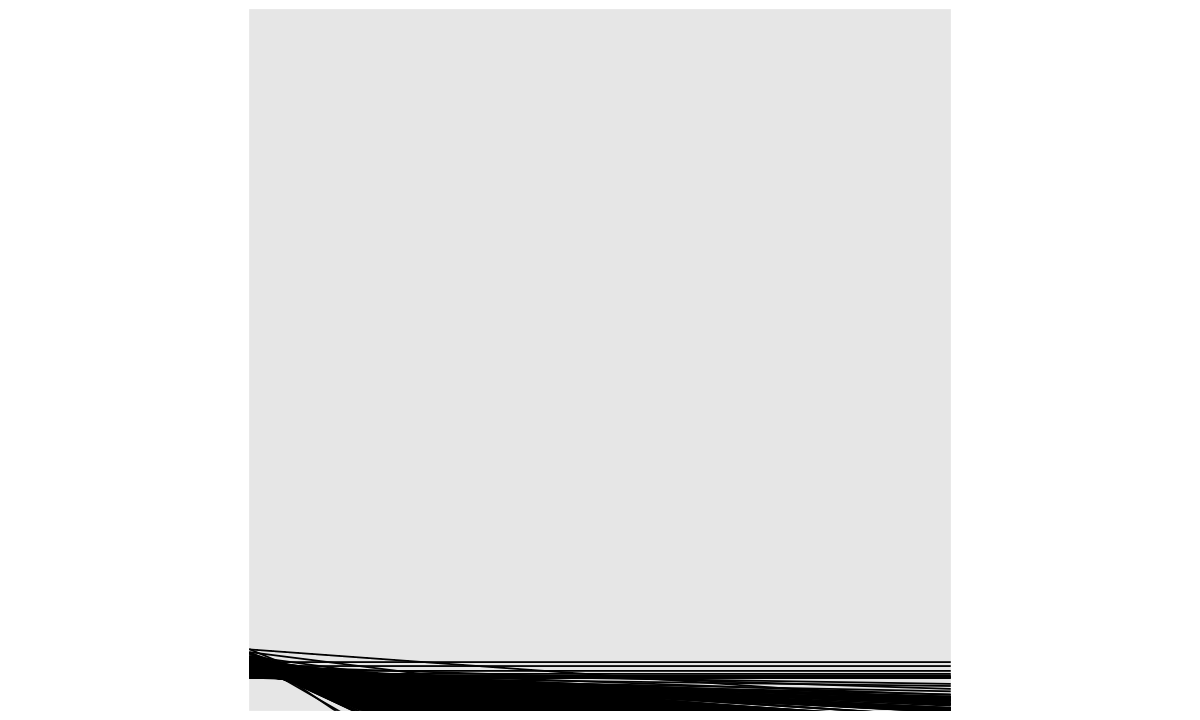

In [616]:
fips_trips %>%
    sample_n(500) %>%
    transmute(y=count/households,
           x=inc_075_100k,
           slope=-x/(1-x),
           county=county_name,
           intercept=y-y*slope) %>%
ggplot() + 
    geom_abline(mapping=aes(slope=slope, intercept=intercept)) + 
    coord_cartesian(xlim=c(0,1), ylim=c(0,1)) + coord_fixed()
    #geom_point(color=red) 
#tibble(x=c(0,1,1,0), y=c(0,0,1,1))

We plot trips/household and mean household income for each census block on a log-log scale, and group by county. We see a remarkably consistent upward trend in usage across income.

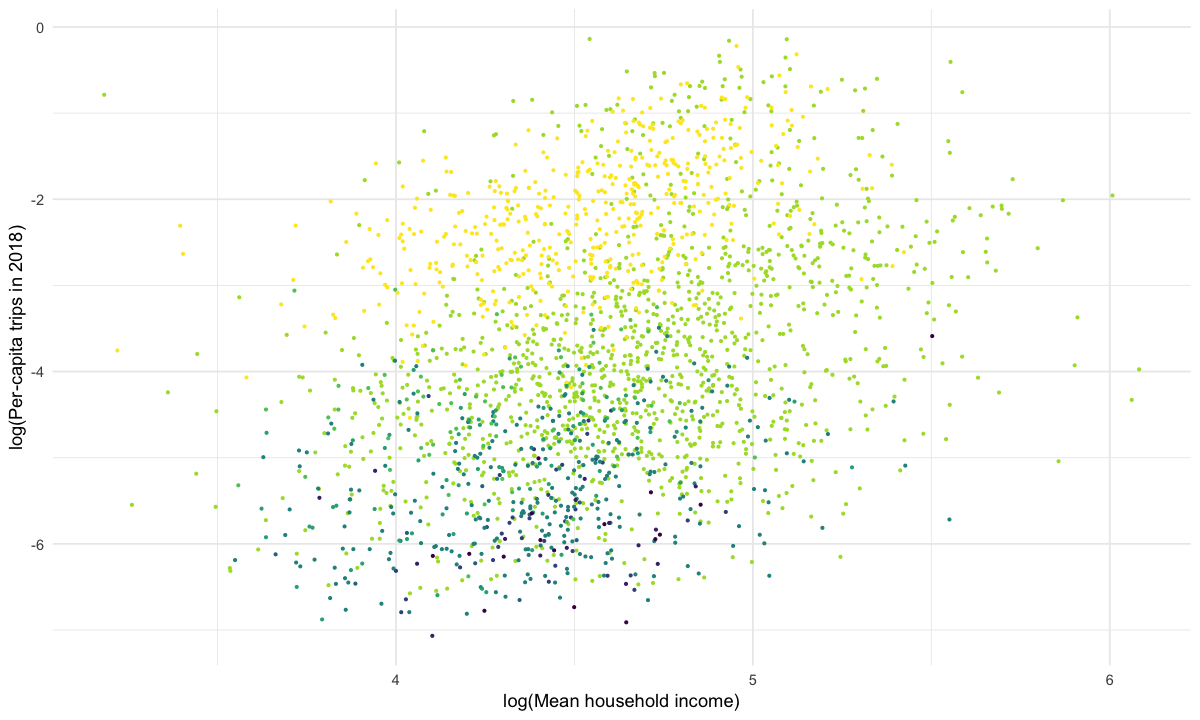

In [21]:
ggplot(fips_trips, aes(log(mean_inc/1000), log(count/households), color=reorder(county, count))) + 
    geom_point(size=0.5) +
    #geom_smooth(method=lm, se=F) +
    scale_color_viridis_d() + 
    guides(color=F) +
    labs(x="log(Mean household income)", y="log(Per-capita trips in 2018)") +
    theme_minimal()

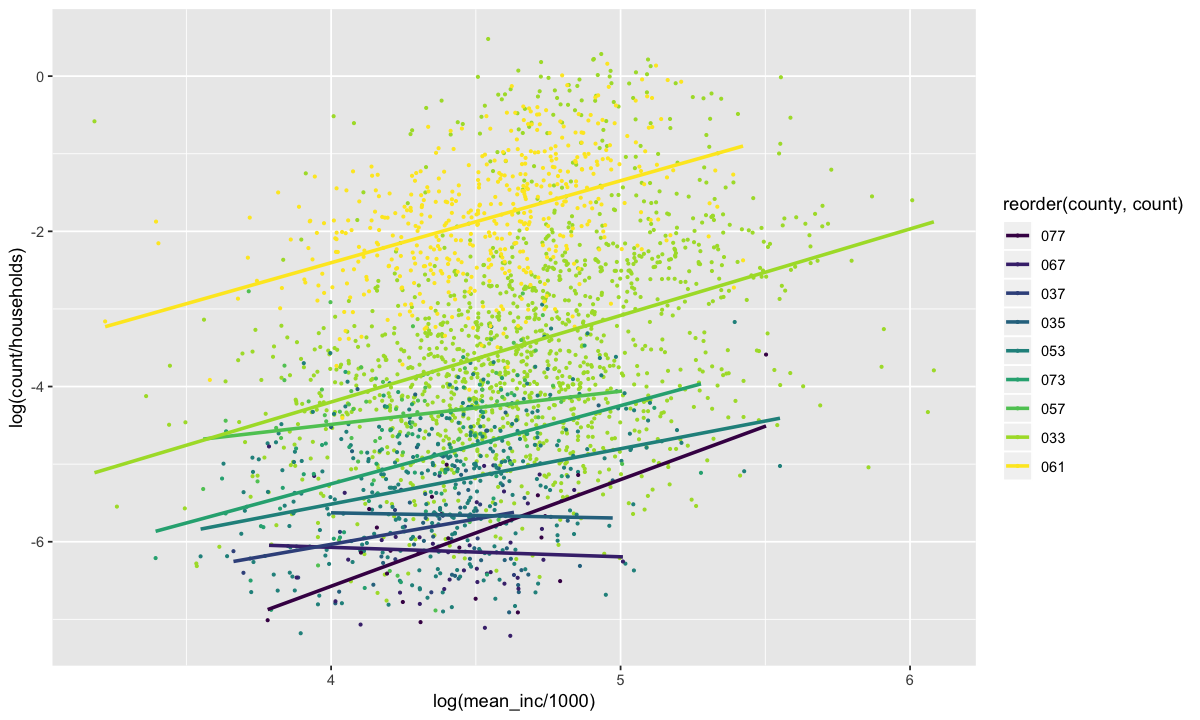

In [24]:
ggplot(fips_trips, aes(log(mean_inc/1000), log(count/households), color=reorder(county, count))) + 
    geom_point(size=0.5) +
    geom_smooth(method=lm, se=F) +
    scale_color_viridis_d()

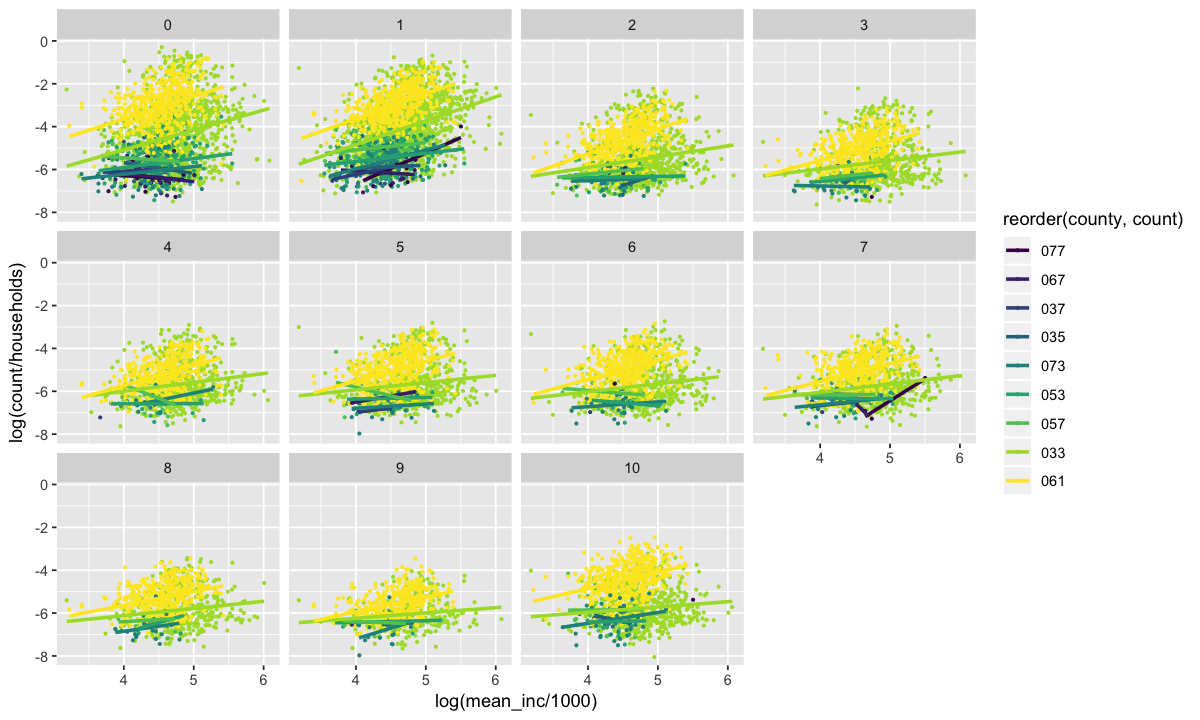

In [15]:
ggplot(fips_trips, aes(log(mean_inc/1000), log(count/households), color=reorder(county, count))) + 
    facet_wrap("toll") +
    geom_point(size=0.5) +
    geom_smooth(method=lm, se=F) +
    scale_color_viridis_d()

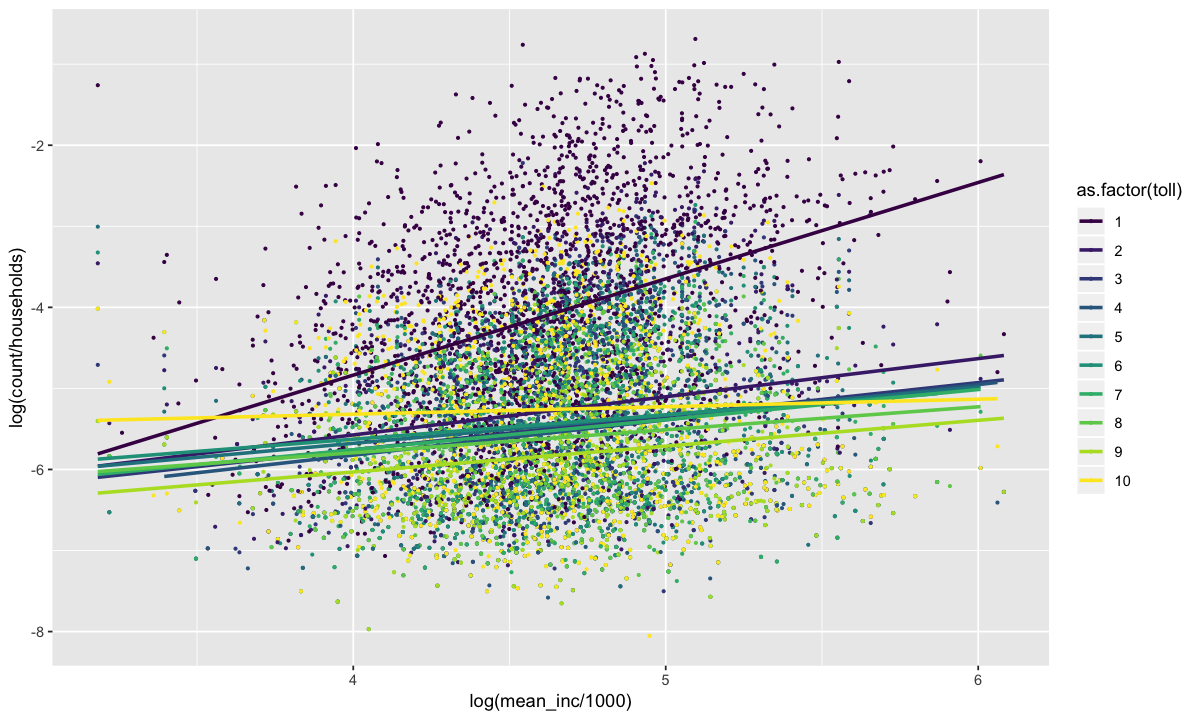

In [36]:
ggplot(fips_trips, aes(log(mean_inc/1000), log(count/households), color=as.factor(toll))) + 
    geom_point(size=0.5) +
    geom_smooth(method=lm, se=F) +
    scale_color_viridis_d()

We fit a random effects model to the above data, allowing intercepts and slopes to vary by census tract.  
The idea here is that block groups within the same tract will have the same spatial effects, allowing for 
unbiased estimation of the coefficient on mean income.  We rescale income to aid in REML fitting.

In [37]:
m = lmer(log(count/households) ~ log(mean_inc/1000)*toll + (log(mean_inc/1000)|tract), data=fips_trips, 
         control=lmerControl(check.nobs.vs.nRE="ignore", optCtrl=list(ftol_abs=1e-9, xtol_abs=1e-9)))
summary(m)

Linear mixed model fit by REML ['lmerMod']
Formula: 
log(count/households) ~ log(mean_inc/1000) * toll + (log(mean_inc/1000) |  
    tract)
   Data: fips_trips
Control: 
lmerControl(check.nobs.vs.nRE = "ignore", optCtrl = list(ftol_abs = 1e-09,  
    xtol_abs = 1e-09))

REML criterion at convergence: 29836.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4684 -0.6800 -0.1037  0.5508  4.0963 

Random effects:
 Groups   Name               Variance Std.Dev. Corr 
 tract    (Intercept)        2.2506   1.5002        
          log(mean_inc/1000) 0.1527   0.3907   -0.93
 Residual                    0.7073   0.8410        
Number of obs: 11305, groups:  tract, 756

Fixed effects:
                         Estimate Std. Error t value
(Intercept)             -8.232024   0.226149 -36.401
log(mean_inc/1000)       0.750233   0.049929  15.026
toll                     0.221313   0.031143   7.106
log(mean_inc/1000):toll -0.082524   0.006683 -12.348

Correlation of Fixed Effects:
     

In [22]:
m = lmer(log(count/households) ~ log(mean_inc/1000) + (log(mean_inc/1000)|tract), data=fips_trips, 
         control=lmerControl(check.nobs.vs.nRE="ignore", optCtrl=list(ftol_abs=1e-9, xtol_abs=1e-9)))
summary(m)

Linear mixed model fit by REML ['lmerMod']
Formula: log(count/households) ~ log(mean_inc/1000) + (log(mean_inc/1000) |  
    tract)
   Data: fips_trips
Control: 
lmerControl(check.nobs.vs.nRE = "ignore", optCtrl = list(ftol_abs = 1e-09,  
    xtol_abs = 1e-09))

REML criterion at convergence: 6130.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3941 -0.4866  0.0557  0.5121  5.4776 

Random effects:
 Groups   Name               Variance Std.Dev. Corr 
 tract    (Intercept)        2.9015   1.7034        
          log(mean_inc/1000) 0.1329   0.3645   -0.69
 Residual                    0.3115   0.5581        
Number of obs: 2354, groups:  tract, 756

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        -6.45192    0.24568  -26.26
log(mean_inc/1000)  0.56050    0.05379   10.42

Correlation of Fixed Effects:
            (Intr)
lg(m_/1000) -0.980

Per [Zax (2018)](https://www.colorado.edu/faculty/zax/sites/default/files/attached-files/goodmans_identity.pdf),
we test the neighborhood model (geography determines everything, with no effect on income within census blocks) in various ways.
The tests are somewhat inconclusive; the neighborhood model might be appropriate here. Geographic factors do seem to be the most important.

In [303]:
m4 = lm(log(count/households) ~ log(mean_inc/1000)*tract + I(log(mean_inc/1000)^2), data=fips_trips)

In [318]:
m5 = lm(log(count/households) ~ tract + log(mean_inc/1000):tract + I(log(mean_inc/1000) - log(mean_inc/1000)^2), data=fips_trips)

In [313]:
broom::tidy(m4) %>% filter(!str_detect(term, "tract"))
broom::glance(m4)

term                    estimate    std.error statistic   p.value  
1 (Intercept)              0.54464165 6.403888   0.08504859 0.9322381
2 log(mean_inc/1000)       0.27802182 2.665184   0.10431617 0.9169373
3 I(log(mean_inc/1000)^2) -0.06651852 0.287535  -0.23134059 0.8170929

r.squared adj.r.squared sigma     statistic p.value df   logLik    AIC     
1 0.9581338 0.8915781     0.7270869 14.39598  0       1764 -1793.557 7117.114
  BIC      deviance df.residual
1 17642.01 586.2788 1109

In [319]:
broom::tidy(m5) %>% filter(!str_detect(term, "tract"))
broom::glance(m5)

term                                         estimate   std.error statistic 
1 (Intercept)                                  0.54464165 6.403888  0.08504859
2 I(log(mean_inc/1000) - log(mean_inc/1000)^2) 0.06651852 0.287535  0.23134059
  p.value  
1 0.9322381
2 0.8170929

r.squared adj.r.squared sigma     statistic p.value df   logLik    AIC     
1 0.9581338 0.8915781     0.7270869 14.39598  0       1764 -1793.557 7117.114
  BIC      deviance df.residual
1 17642.01 586.2788 1109

In [315]:
anova(m4, m5)

Res.Df RSS      Df Sum of Sq     F  Pr(>F)
1 1109   586.2788 NA            NA NA NA    
2 1109   586.2788  0 -1.045919e-11 NA NA

In [271]:
m2 = lmer(log(count/households) ~ log(mean_inc/1000) + (1|tract), data=fips_trips, 
         control=lmerControl(optCtrl=list(ftol_abs=1e-8, xtol_abs=1e-8)))
summary(m2)

Linear mixed model fit by REML ['lmerMod']
Formula: log(count/households) ~ log(mean_inc/1000) + (1 | tract)
   Data: fips_trips
Control: lmerControl(optCtrl = list(ftol_abs = 1e-08, xtol_abs = 1e-08))

REML criterion at convergence: 9500.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5142 -0.3796  0.0435  0.4152  5.4408 

Random effects:
 Groups   Name        Variance Std.Dev.
 tract    (Intercept) 4.4594   2.1117  
 Residual             0.5902   0.7683  
Number of obs: 2873, groups:  tract, 907

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        -3.09975    0.29498  -10.51
log(mean_inc/1000)  0.67346    0.06316   10.66

Correlation of Fixed Effects:
            (Intr)
lg(m_/1000) -0.970

In [294]:
m3 = lmer(log(count/households) ~ log(mean_inc/1000) + I(log(mean_inc/1000)^2) + (1|tract), data=fips_trips, 
         control=lmerControl(optCtrl=list(ftol_abs=1e-8, xtol_abs=1e-8)))
summary(m3)

Linear mixed model fit by REML ['lmerMod']
Formula: 
log(count/households) ~ log(mean_inc/1000) + I(log(mean_inc/1000)^2) +  
    (1 | tract)
   Data: fips_trips
Control: lmerControl(optCtrl = list(ftol_abs = 1e-08, xtol_abs = 1e-08))

REML criterion at convergence: 9500.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4878 -0.3868  0.0434  0.4188  5.2776 

Random effects:
 Groups   Name        Variance Std.Dev.
 tract    (Intercept) 4.4497   2.1094  
 Residual             0.5901   0.7682  
Number of obs: 2873, groups:  tract, 907

Fixed effects:
                        Estimate Std. Error t value
(Intercept)              0.09843    1.75686   0.056
log(mean_inc/1000)      -0.74683    0.77155  -0.968
I(log(mean_inc/1000)^2)  0.15643    0.08467   1.847

Correlation of Fixed Effects:
            (Intr) l(_/10
lg(m_/1000) -0.996       
I((_/1000)^  0.986 -0.997

In [295]:
broom::glance(m)
broom::glance(m2)
anova(m, m2, m3)

sigma     logLik    AIC      BIC     deviance df.residual
1 0.7432711 -4737.521 9487.042 9522.82 9468.153 2867

sigma     logLik    AIC      BIC      deviance df.residual
1 0.7682583 -4750.286 9508.572 9532.424 9493.455 2869

refitting model(s) with ML (instead of REML)


Df AIC      BIC      logLik    deviance Chisq     Chi Df Pr(>Chisq)  
m2 4  9501.455 9525.307 -4746.727 9493.455        NA NA               NA
m3 5  9500.041 9529.856 -4745.020 9490.041  3.414314  1     6.463328e-02
m  6  9480.152 9515.930 -4734.076 9468.152 21.888792  1     2.889165e-06

Back to our main model, we have concerns about heteroskedasticity and non-normal errors.

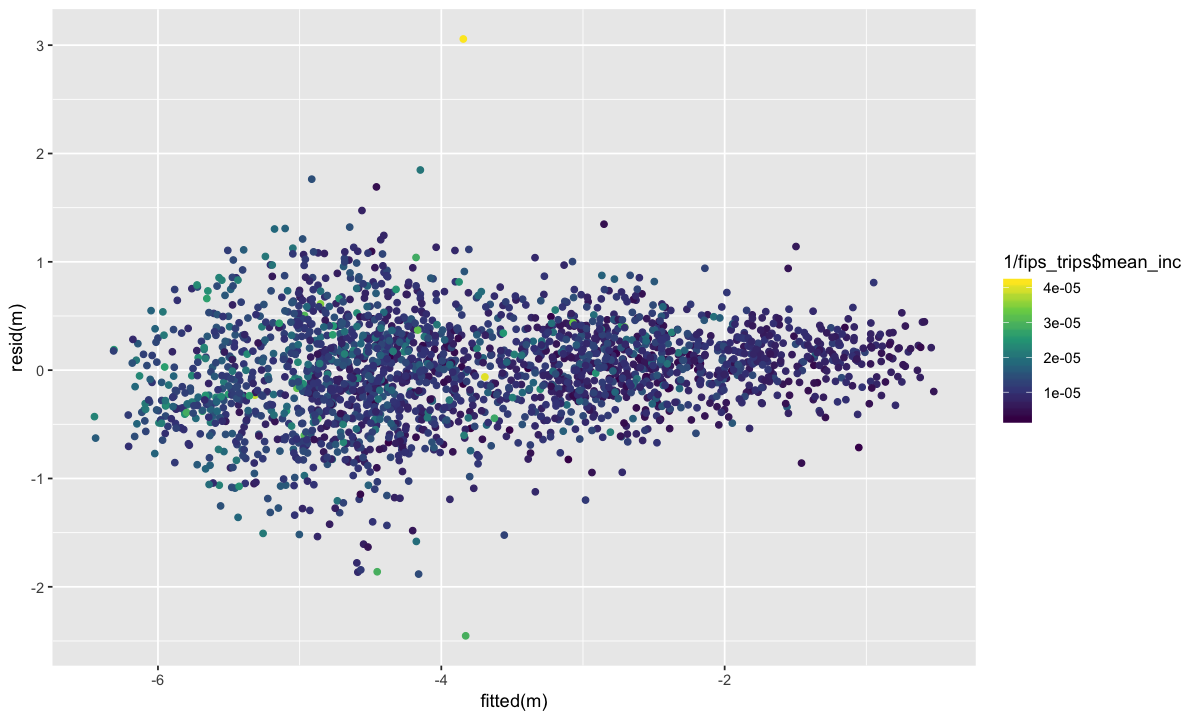

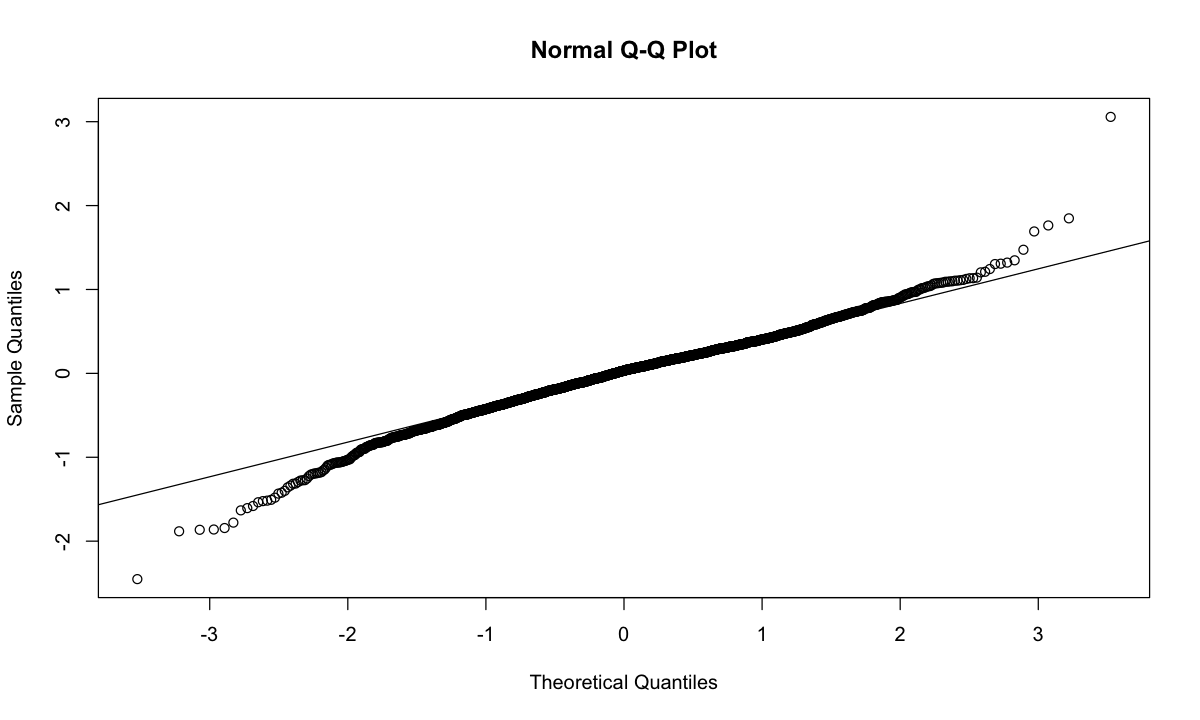

In [24]:
qplot(fitted(m), resid(m), color=1/fips_trips$mean_inc)
qqnorm(resid(m))
qqline(resid(m))

---
With our fitted model in hand, we can draw from the population income distribution and simulate individual trip counts, then aggregate to estimate population quantities of interest

In [25]:
incomes = rdagum(1e5, b, a, p)

In [26]:
tracts = rep(1:2000, 1e5/2000)

In [27]:
counts = simulate(m, nsim=1, newdata=tibble(mean_inc=1000*incomes, tract=tracts), 
                  re.form=NULL, allow.new.levels=T)$sim_1
counts=exp(counts)

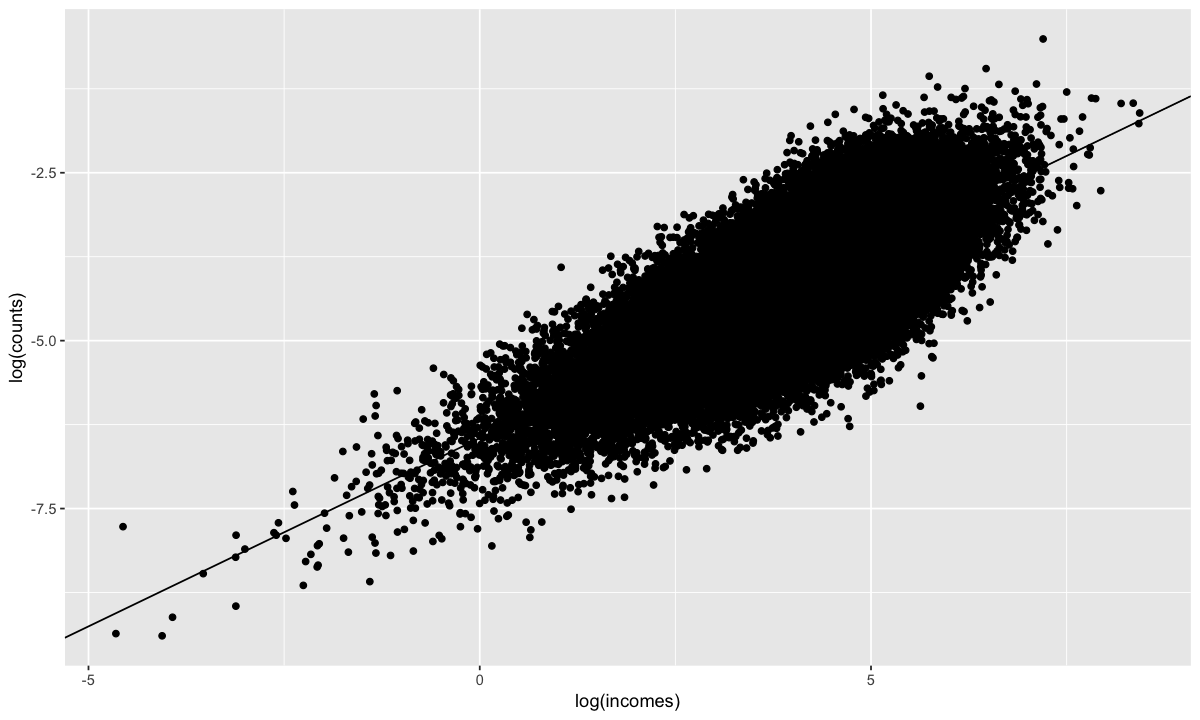

In [30]:
qplot(log(incomes),log(counts)) + 
    geom_abline(slope=mcoef[2], intercept=mcoef[1])

As we would hope, there is remarkable agreement between the individual mean count and the median count of the census-block means.

In [595]:
summary(counts)
summary(fips_trips$count/fips_trips$households)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
7.127e-05 7.094e-03 1.146e-02 1.410e-02 1.799e-02 1.685e-01 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0006418 0.0058708 0.0136452 0.0412647 0.0494571 0.5222672 

We can plot the models' implied income/usage curve

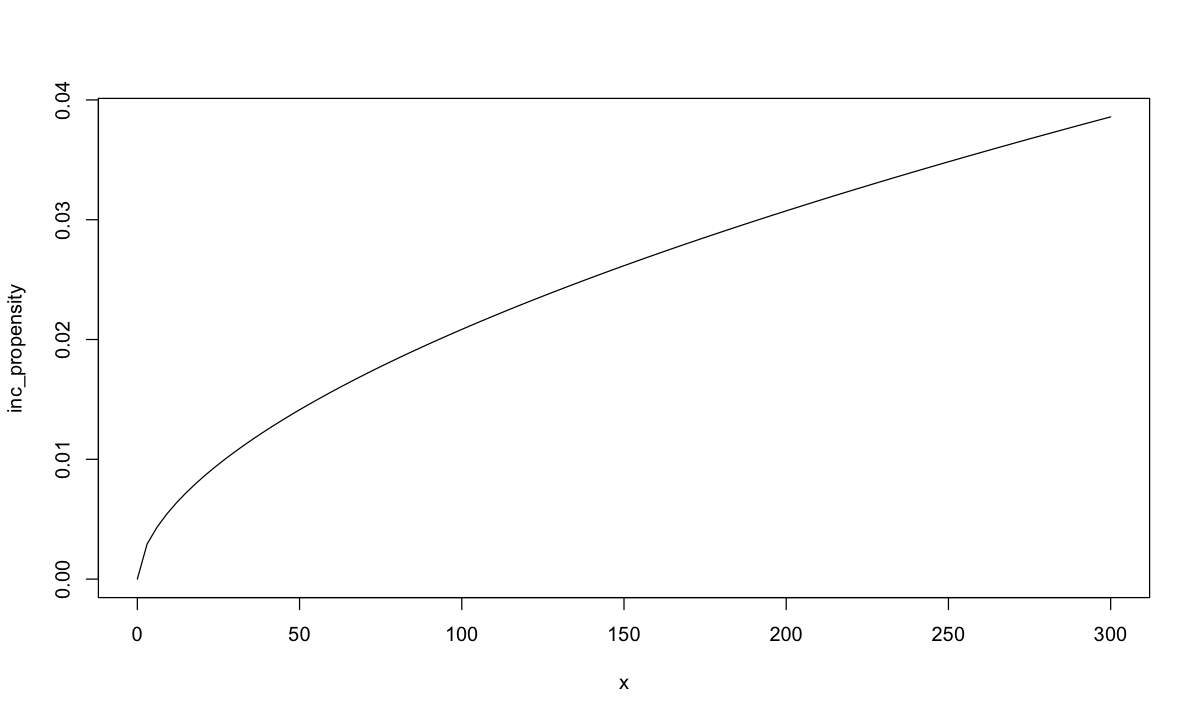

In [29]:
mcoef = colMeans(coef(m)$tract)
inc_propensity = function(income)  exp(log(income)*mcoef[2] + mcoef[1])
plot(inc_propensity, xlim=c(0, 300))

And we can plot the estimated distribution of income on the facility (black) verus the population (blue)

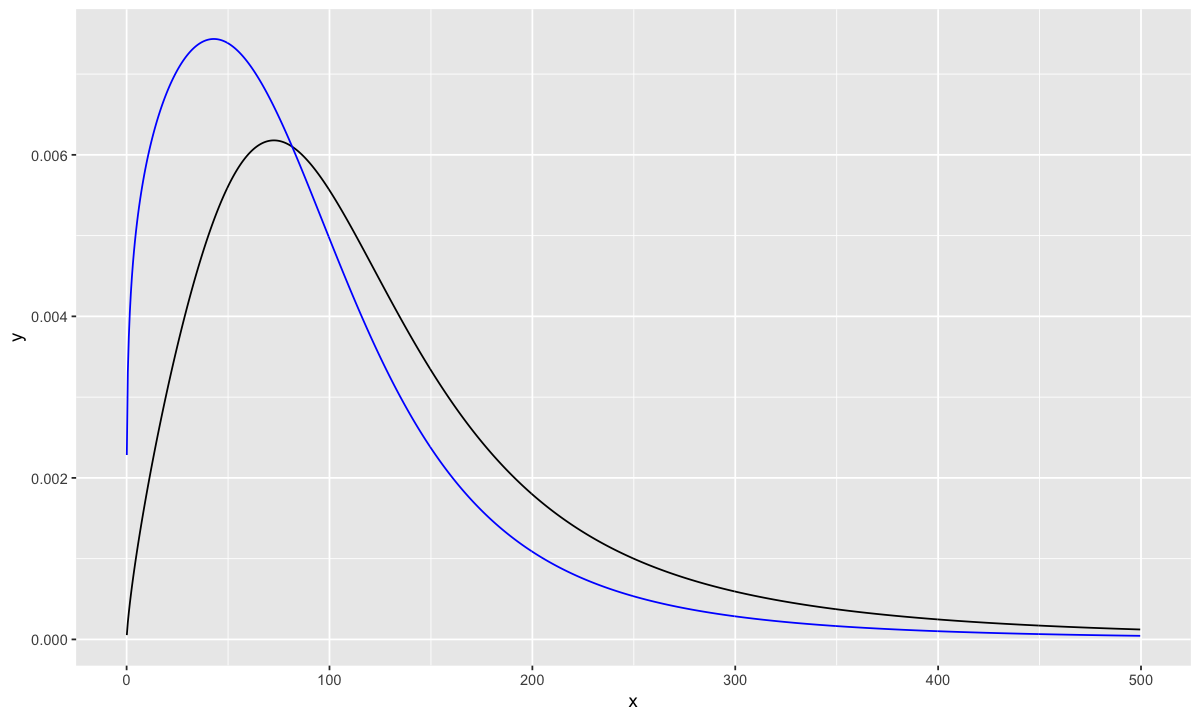

In [31]:
x = seq(0.1, 500, 0.5)
norm = integrate(function(x) inc_propensity(x)*ddagum(x, b, a, p), 0.01, 1e3)
ggplot(NULL) + 
    annotate("line", x=x, y=inc_propensity(x)*ddagum(x, b, a, p)/norm$value) + 
    annotate("line", x=x, y=ddagum(x, b, a, p), color='blue')

Using these estimated densities, we can calculate a median income of facility users.

In [32]:
norm = integrate(function(x) inc_propensity(x)*ddagum(x, b, a, p), 0.01, 1e3)
ddens = function(x) inc_propensity(x)*ddagum(x, b, a, p)/norm$value
pdens = function(q) (integrate(ddens, 0, q)$value - 0.5)
uniroot(pdens, c(0, 200))$root

[1] 105.7105

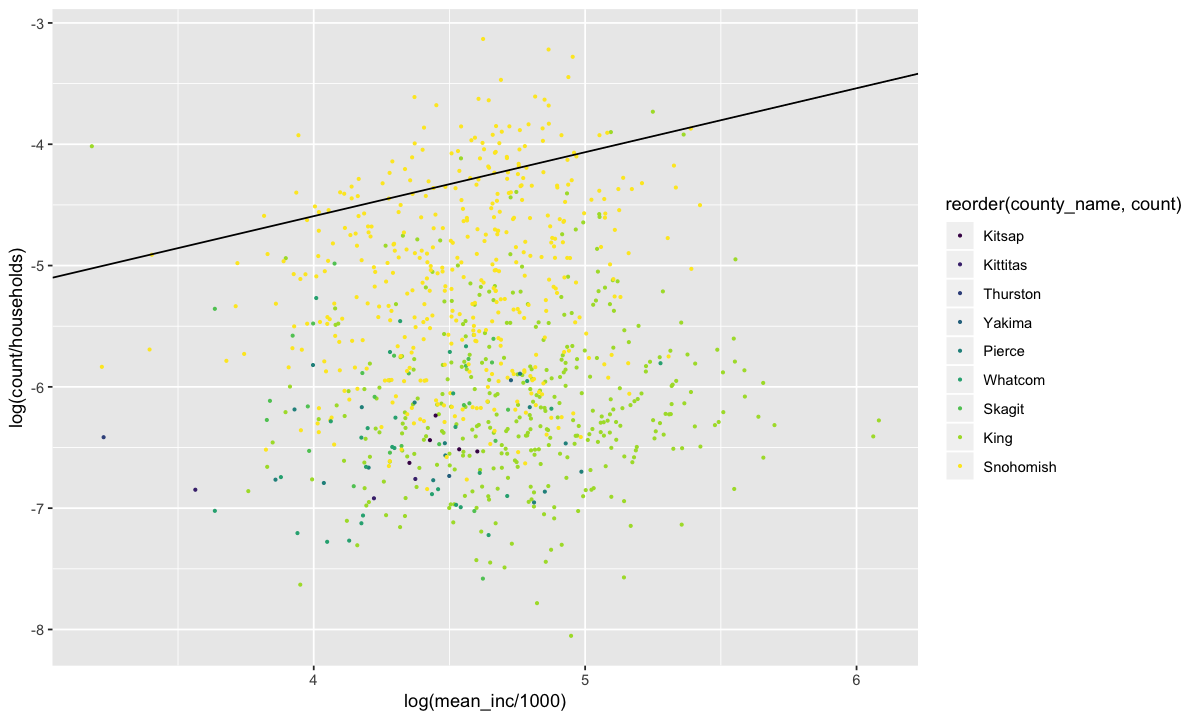

In [623]:
ggplot(fips_trips, aes(log(mean_inc/1000), log(count/households))) + 
    geom_point(aes(color=reorder(county_name, count)), size=0.5) +
    geom_abline(slope=mcoef[2], intercept=mcoef[1]) +
    scale_color_viridis_d()

This is the fitting of bins to the simulated data mentioned above.

In [37]:
simul_indiv_fit = tibble(group="Ecological Inference", 
                   inc_000_020k = weighted.mean(incomes >= 0 & incomes < 20, w=counts),
                   inc_020_035k = weighted.mean(incomes >= 20 & incomes < 35, w=counts),
                   inc_035_050k = weighted.mean(incomes >= 35 & incomes < 50, w=counts),
                   inc_050_075k = weighted.mean(incomes >= 50 & incomes < 75, w=counts),
                   inc_075_100k = weighted.mean(incomes >= 75 & incomes < 100, w=counts),
                   inc_100_125k = weighted.mean(incomes >= 100 & incomes < 125, w=counts),
                   inc_125_150k = weighted.mean(incomes >= 125 & incomes < 150, w=counts),
                   inc_150_200k = weighted.mean(incomes >= 150 & incomes < 200, w=counts),
                   inc_200_infk = weighted.mean(incomes >= 200, w=counts),
                   count = sum(counts)) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = pct*count)

group     count     inc_group    pct       
1 Synthetic  76.70254 inc_000_020k 0.03502410
2 Synthetic 122.84047 inc_020_035k 0.05609171
3 Synthetic 170.27437 inc_035_050k 0.07775110
4 Synthetic 325.25086 inc_050_075k 0.14851684
5 Synthetic 322.53813 inc_075_100k 0.14727814
6 Synthetic 273.92484 inc_100_125k 0.12508022
7 Synthetic 211.10506 inc_125_150k 0.09639531
8 Synthetic 273.62594 inc_150_200k 0.12494374
9 Synthetic 413.73099 inc_200_infk 0.18891885

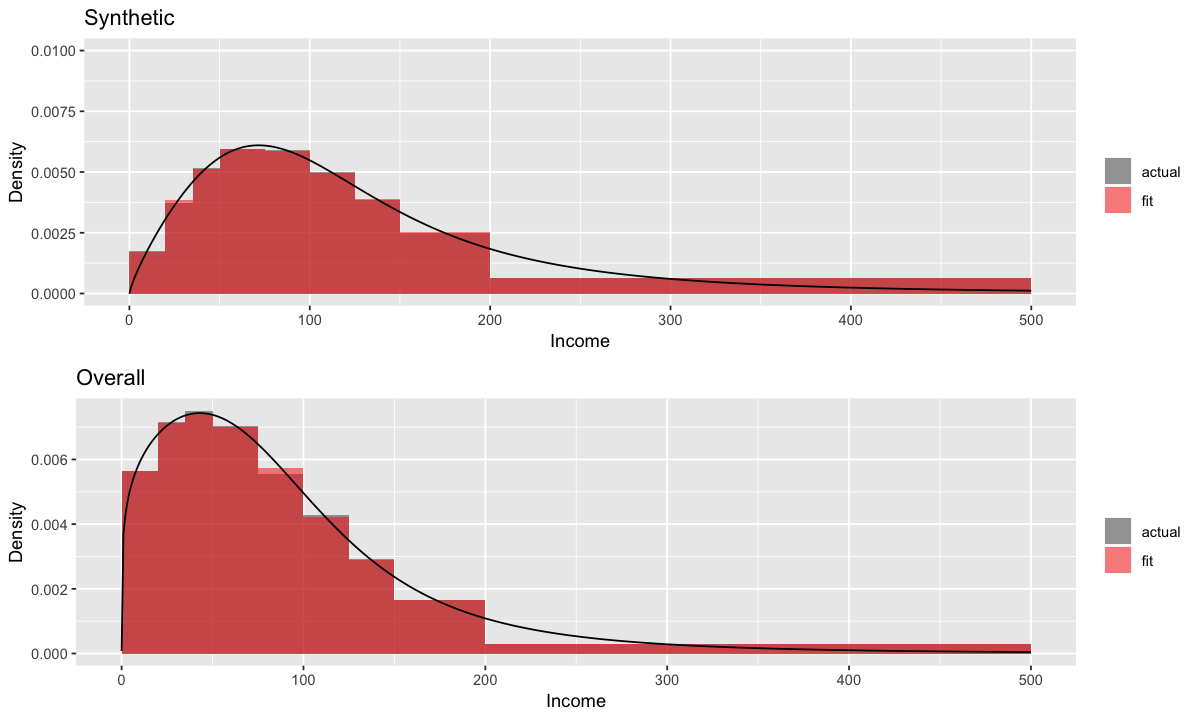

In [34]:
simul_indiv_fit
simul_fit = fit_dagum(simul_indiv_fit$count)

p1 = plot(simul_fit, 500) + labs(title="Synthetic") + ylim(0, 0.01)
#p1 = qplot(x, ddens(x), geom="line") + labs(title="Synthetic", x="Income", y="Density")
p2 = plot(fit_dagum(all_counts$count, acs_bins), 500) + labs(title="Overall")

gridExtra::grid.arrange(p1, p2, nrow=2)

Comparing these results to our earlier method of estimation, we see that the earlier method substantially underestimated the proportion of wealthy users, and overestimated the proportion of poor users.

In [35]:
current_counts = fips_trips %>%
    summarize_at(vars(starts_with("inc")), ~ sum(. * count)) %>%
    mutate(group="Current Method") %>%
    gather(inc_group, count, -group) %>%
    mutate(pct = count / sum(count))

[1] "$106,644"

[1] "$95,032.44"

[1] "$74,020.37"

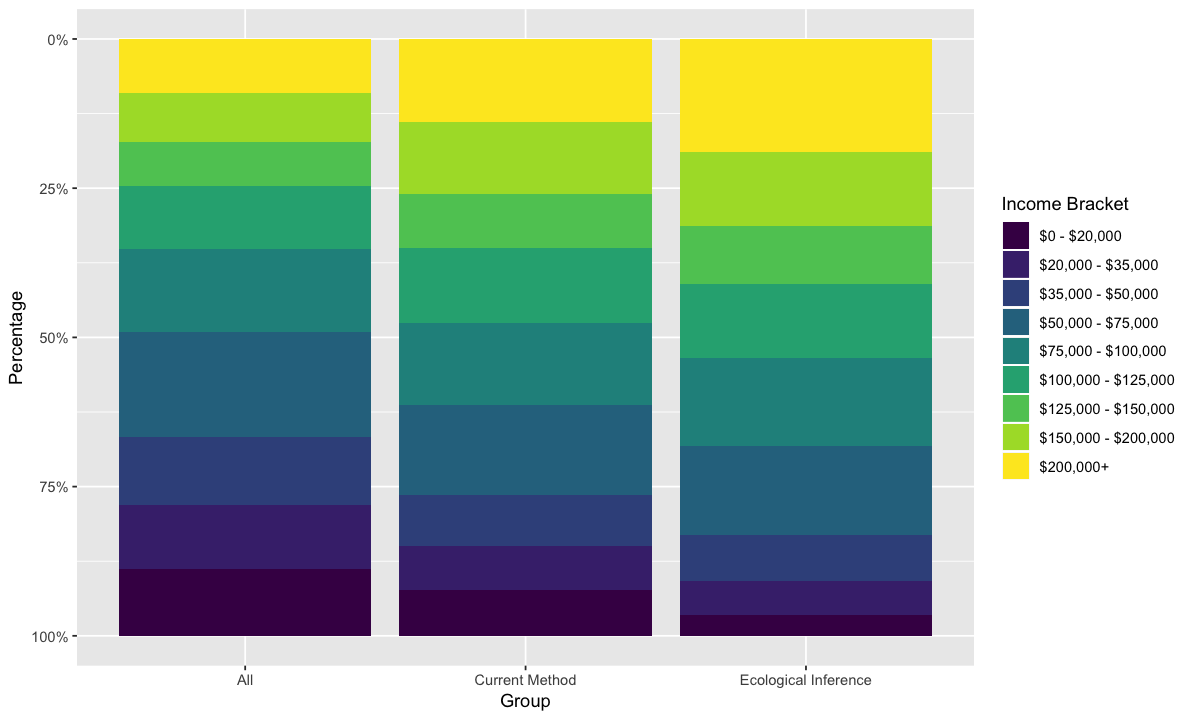

In [38]:
scales::dollar(1000*median(simul_fit))
scales::dollar(1000*median(fit_dagum(current_counts$count, acs_bins)))
scales::dollar(1000*median(fit_dagum(all_counts$count, acs_bins)))

simul_indiv_fit %>% 
    bind_rows(all_counts) %>%
    bind_rows(current_counts) %>%
    select(-count) %>% 
    spread(inc_group, pct) %>%
    plot_inc_stacked

### Errors and Uncertainty

We can use information from the model fit to estimate the uncertainty in our population estimates. Since there is very little estimated error in the population income model, we ignore it.

In [604]:
scales::dollar(1000*median(fit_all))
scales::dollar(1000*median_se(fit_all))

[1] "$74,020.37"

[1] "$132.42"

Parametric and nonparametric bootstrapping of the coefficients shows that the REML-estimated standard errors may be to small, but only slightly so.

In [628]:
broom::tidy(m)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

term                                     estimate   std.error  statistic 
1 (Intercept)                              -6.5885563 0.34833562 -18.914391
2 log(mean_inc/1000)                        0.1702460 0.07560587   2.251756
3 sd_(Intercept).tract                      0.5411355         NA         NA
4 sd_log(mean_inc/1000).tract               0.1662449         NA         NA
5 cor_(Intercept).log(mean_inc/1000).tract -0.5196975         NA         NA
6 sd_Observation.Residual                   0.5823507         NA         NA
  group   
1 fixed   
2 fixed   
3 tract   
4 tract   
5 tract   
6 Residual

In [117]:
bootMer(m, fixef, nsim=100, use.u=F, type="parametric")


74 warning(s): Model failed to converge with max|grad| = 0.00201732 (tol = 0.002, component 1) (and others)




PARAMETRIC BOOTSTRAP


Call:
bootMer(x = m, FUN = fixef, nsim = 100, use.u = F, type = "parametric")


Bootstrap Statistics :
      original      bias    std. error
t1* -3.3234051 -0.05618969  0.36732111
t2*  0.7241529  0.01261314  0.07725942

In [123]:
0.35536415/0.33257088
0.07740554/0.07084331

[1] 1.068537

[1] 1.09263

In [119]:
est_m = function(d, i) {
    d = d[i,]
    m = lmer(log(count/households) ~ log(mean_inc/100000) + (log(mean_inc/100000)|tract), data=d, 
         control=lmerControl(optCtrl=list(ftol_abs=1e-8, xtol_abs=1e-8)))
    fixef(m)
}

bm = boot(fips_trips, est_m, R=100, strata=fips_trips$tract)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00396695 (tol = 0.002, component 1)”

In [120]:
bm


STRATIFIED BOOTSTRAP


Call:
boot(data = fips_trips, statistic = est_m, R = 100, strata = fips_trips$tract)


Bootstrap Statistics :
      original      bias    std. error
t1* 0.01143991 -0.00668747  0.02009114
t2* 0.72414692  0.07236008  0.07423842

In [122]:
0.07423842/0.07084331

[1] 1.047924

We can estimate the median by calculating a weighted Dagum pdf and integrating.

In [366]:
mcoef

(Intercept) log(mean_inc/1000) 
        -3.3234051          0.7241529

In [127]:
ddens = function(x) inc_propensity(x)*ddagum(x, b, a, p)/norm$value
pdens = function(q) (integrate(ddens, 0, q)$value - 0.5)

In [553]:
est_med = function(slope, b, a, p) {
    pred_count = function(x) exp(slope*log(x))
    norm = integrate(function(x) pred_count(x)*ddagum(x, b, a, p), 0.01, 1e4)$value
    ddens = function(x) pred_count(x)*ddagum(x, b, a, p)/norm
    pdens = function(q) (integrate(ddens, 0, q)$value - 0.5)
    uniroot(pdens, c(1, 300))$root
}

There is an interesting relationship.  Errors in the intercepts have no effect on the estimated median.
Errors in the slopes have a perfectly linear effect on the median, but the linear effect varies by the average slope.
Even more surprising, the linear effect's slope itself seems to follow a fourth-degree polynomial in the estimated 
slope coefficient.

In [554]:
slopes = rnorm(50, 0, 0.1)

est_rel = function(y) {
    meds = sapply(1:length(slopes), function(x) est_med(slopes[x] + y, b, a, p))
    coef(lm(meds ~ slopes + I(slopes^2)))[2]
}


Call:
lm(formula = meds ~ slopes + I(slopes^2))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.077411 -0.013982  0.003582  0.011832  0.074037 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 1.165e+02  3.412e-03 34144.95   <2e-16 ***
slopes      6.499e+01  3.555e-02  1828.18   <2e-16 ***
I(slopes^2) 1.717e+01  2.644e-01    64.93   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01969 on 47 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 2.249e+06 on 2 and 47 DF,  p-value: < 2.2e-16


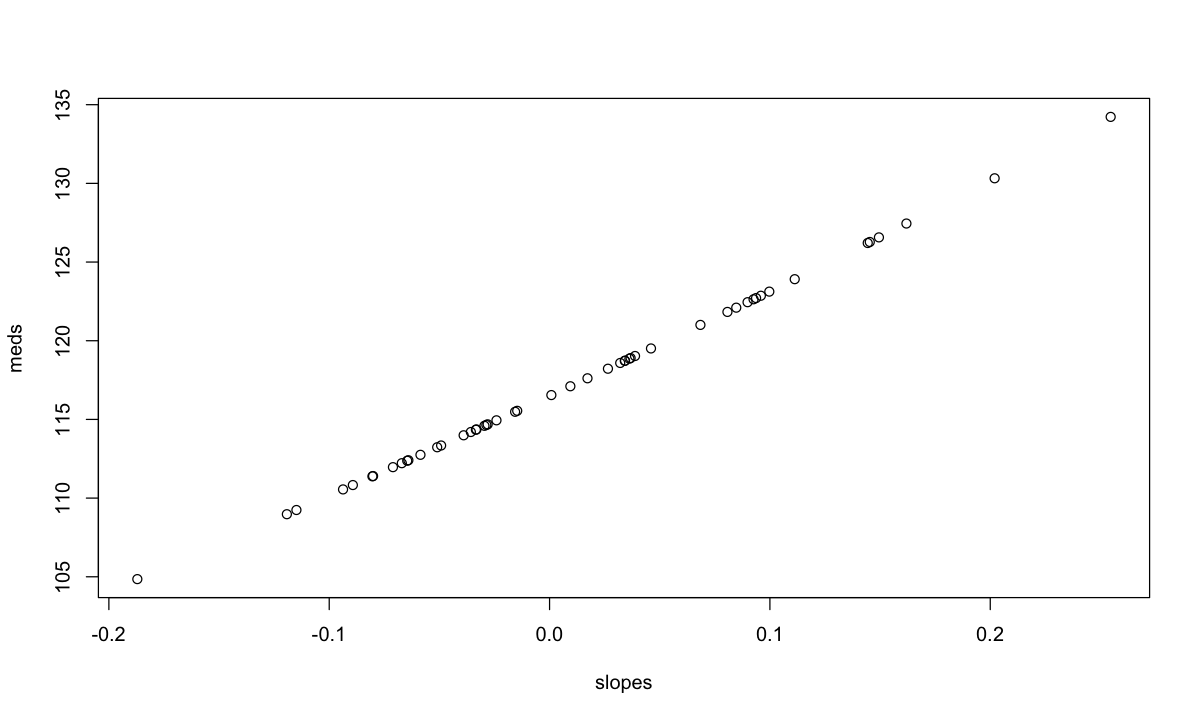

In [555]:
meds = sapply(1:length(slopes), function(x) est_med(slopes[x] + mcoef[2], b, a, p))
lm(meds ~ slopes + I(slopes^2)) %>% summary
plot(slopes, meds)

In [513]:
ys = seq(-0.3, 1, length.out=30)
rels = sapply(ys, est_rel)

In [514]:
ys[which.min(rels)]

[1] 0.1931034

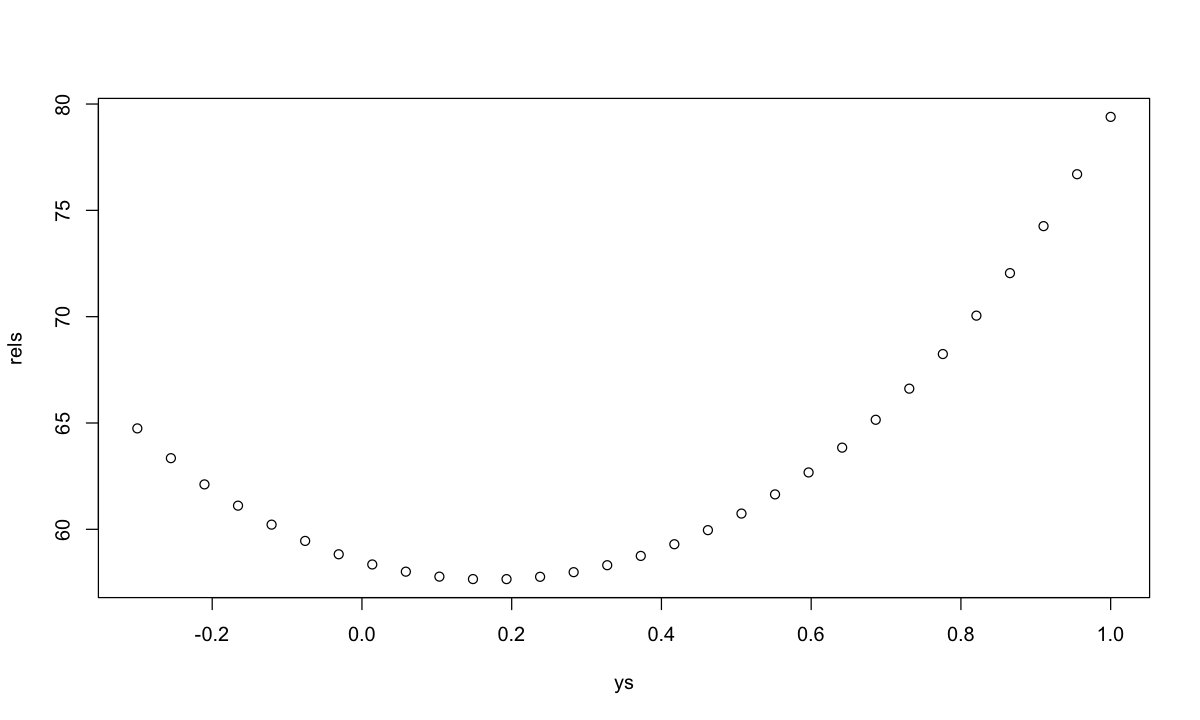

In [515]:
plot(ys, rels)


Call:
lm(formula = rels ~ ys + I(ys^2) + I(ys^3) + I(ys^4))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.019833 -0.009489 -0.004270  0.010011  0.034209 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)  58.493013   0.005727 10213.45   <2e-16 ***
ys          -10.017331   0.025247  -396.77   <2e-16 ***
I(ys^2)      31.625834   0.094083   336.15   <2e-16 ***
I(ys^3)     -11.875770   0.265975   -44.65   <2e-16 ***
I(ys^4)      11.141647   0.184741    60.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0155 on 25 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.102e+06 on 4 and 25 DF,  p-value: < 2.2e-16


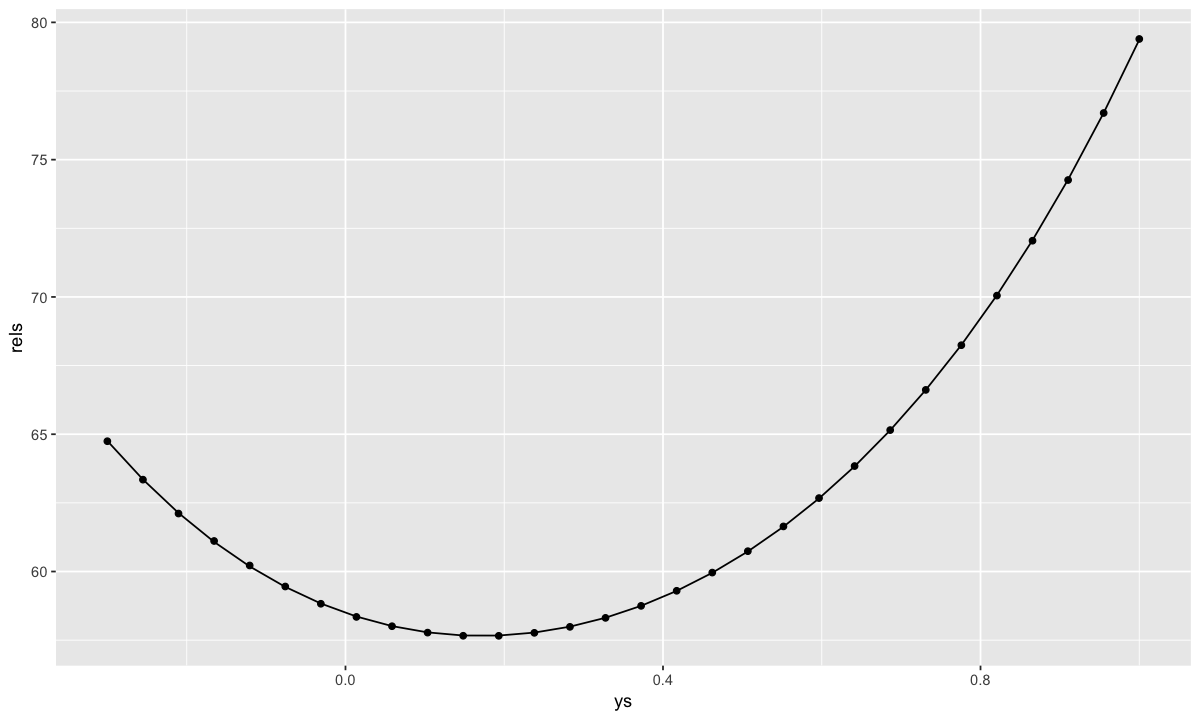

In [516]:
var.m = lm(rels ~ ys + I(ys^2) + I(ys^3) + I(ys^4))
summary(var.m)
qplot(ys, rels) + annotate('line', x=ys, y=fitted(var.m))

In [517]:
coef(var.m)

(Intercept)          ys     I(ys^2)     I(ys^3)     I(ys^4) 
   58.49301   -10.01733    31.62583   -11.87577    11.14165

In [518]:
pred_median_se = function(slope, se) {
    est_rel = 58.493013270862 - 10.0173306264074*slope + 31.625834062504*slope^2 - 
        11.8757699718388*slope^3 + 11.1416469544929*slope^4
    est_se = est_rel * se
    names(est_se) = NULL
    est_se
}

In [655]:
pred_median_se(mcoef[2], 0.04153)
#sqrt(median_se(fit_all)^2+pred_median_se(mcoef[2], 0.04808)^2)
median_se(simul_fit)

[1] 2.538613

[1] 21.16798

In [653]:
broom::tidy(m)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

term                                     estimate    std.error  statistic 
1 (Intercept)                              -6.71586047 0.19386251 -34.642388
2 log(mean_inc/1000)                        0.13078746 0.04152732   3.149432
3 sd_(Intercept).tract                      0.43902212         NA         NA
4 sd_log(mean_inc/1000).tract               0.05124682         NA         NA
5 cor_(Intercept).log(mean_inc/1000).tract -1.00000000         NA         NA
6 sd_Observation.Residual                   0.48557119         NA         NA
  group   
1 fixed   
2 fixed   
3 tract   
4 tract   
5 tract   
6 Residual

In [574]:
se(m)

ERROR: Error in se(m): could not find function "se"
